# 0. Imports

In [1]:
# for data handling and manipulation:
import pandas as pd
import numpy as np

# for os handling
import os

# for pre-processing
from sklearn.preprocessing import StandardScaler

# import the classifiers to fit:
from sklearn.svm import LinearSVC, SVC

# import metrics
from sklearn.metrics import fbeta_score, classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay, make_scorer

# for tabulating results
from tabulate import tabulate

# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# for handling warnings
import warnings

# for hyper-parameter tuning
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.model_selection import GridSearchCV

In [2]:
# Reading the train, test and validation data into this notebook 

X_train_gray = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\X_train_gray.csv').drop(columns = ['Unnamed: 0'], axis = 1)
X_train_gray = X_train_gray.to_numpy()

y_train = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\y_train.csv').drop(columns = ['Unnamed: 0'], axis = 1)
y_train = y_train.to_numpy(dtype = 'int64').flatten()

X_val_gray = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\X_val_gray.csv').drop(columns = ['Unnamed: 0'], axis = 1)
X_val_gray = X_val_gray.to_numpy()

y_val = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\y_val.csv').drop(columns = ['Unnamed: 0'], axis = 1)
y_val = y_val.to_numpy(dtype = 'int64').flatten()

X_test_gray = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\X_test_gray.csv').drop(columns = ['Unnamed: 0'], axis = 1)
X_test_gray = X_test_gray.to_numpy()

y_test = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\y_test.csv').drop(columns = ['Unnamed: 0'], axis = 1)
y_test = y_test.to_numpy(dtype = 'int64').flatten()

In [3]:
X_train_gray.shape, y_train.shape, X_val_gray.shape, y_val.shape, X_test_gray.shape, y_test.shape

((791, 98), (791,), (98, 98), (98,), (100, 98), (100,))

In [4]:
X_final_train_gray = np.concatenate((X_train_gray, X_val_gray), axis = 0)
y_train_final = np.concatenate((y_train, y_val), axis = 0)

## Function to calculate metrics

In [5]:
def calculate_metrics(y_pred, y_true, normalize = False):
    
    with warnings.catch_warnings():
        
        warnings.filterwarnings('ignore')
        # calculate accuracy:
        temp = round(accuracy_score(y_true, y_pred),2)
        print('Accuracy in detecting Accident class: {}'.format(temp))
        print('\n------------------------------------------------------------------------------------------\n')
        
        my_data = []
        cr = classification_report(y_true, y_pred, output_dict = True)

        # calculate precision:
        my_data.append(['Precision',round(cr['0']['precision'],2), round(cr['1']['precision'],2)])

        # calculate recall:
        my_data.append(['Recall',round(cr['0']['recall'],2), round(cr['1']['recall'],2)])

        # f1-score:
        my_data.append(['f1-score',round(cr['0']['f1-score'],2), round(cr['1']['f1-score'],2)])

        head = ['Metric','Non-Accident images','Accident images']

        print(tabulate(my_data, headers = head, tablefmt = 'grid'))
        print('\n------------------------------------------------------------------------------------------\n')

        # calculate sensitivity (recall of positive class for binary classification)
        temp = round(cr['1']['recall'],2)
        print('Sensitivity/ ability to correctly classifiy to Accident class is: {}'.format(temp))
    
        # calculate specificity (recall of negative class for binary classification)
        temp = round(cr['0']['recall'],2)
        print('Specificity/ ability to correctly classifiy to Non-Accident class is: {}'.format(temp))
        print('\n------------------------------------------------------------------------------------------\n')

        # calculate f1-beta score:
        print('Fbeta score with beta = 1.5 is: {}'.format(round(fbeta_score(y_true, y_pred,beta = 1.4),2)))
        print('\n------------------------------------------------------------------------------------------\n')

        # Confusion matrix:

        if normalize == False:
            cm = confusion_matrix(y_true, y_pred)
            disp = ConfusionMatrixDisplay(cm, display_labels = ["Non-Accident", 'Accident'])
            disp.plot()
            plt.title('Confusion Matrix')
            plt.show()
            print('\n------------------------------------------------------------------------------------------\n')

        else:
            cm = confusion_matrix(y_true, y_pred, normalize='all')
            disp = ConfusionMatrixDisplay(cm, display_labels = ["Non-Accident", 'Accident'])
            disp.plot()
            plt.title('Confusion Matrix')
            plt.show()
            print('\n------------------------------------------------------------------------------------------\n')


        # ROC curve:
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        plt.plot(fpr, tpr, marker = 'o')
        plt.xlabel('% of Non-Accidents incorrectly classified')
        plt.ylabel('% of Accidents correctly classified')
        plt.title('ROC Curve')
        plt.show()
        print('\n------------------------------------------------------------------------------------------\n')
        temp = round(auc(fpr, tpr),2)
        print('AUC score is: {}'.format(temp))

    return 

# Fitting a Kernel SVM

## On grayscale images

## Scale the data

In [6]:
scaler = StandardScaler()
X_train_gray_sc = scaler.fit_transform(X_final_train_gray)
X_test_gray_sc = scaler.transform(X_test_gray)

In [7]:
X_train_gray_sc.shape, X_test_gray_sc.shape

((889, 98), (100, 98))

### Let's formally do hyper-parameter tuning, using Bayes Optimization and Grid Search. The default parameters are also an option to use for both Bayes and Grid search CV, if they indeed have the best generalizing capability, then it will get detected.

In [8]:
# parameters1 use `squared hinge loss`, parameters2 use `hinge` loss (as hinge loss is not supported with 'l1' penalty)

parameters = {'C': Real(0.0001,10, 'uniform'), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree':Integer(1,5,'uniform'), 'gamma': Real(1e-3,1e3,'log-uniform'),
              'coef0':Real(-10,10,'uniform')}
            


fbeta_scorer = make_scorer(fbeta_score, beta = 1.4)                                                                     

In [9]:
opt_1 = BayesSearchCV(SVC(random_state = 5000, class_weight = {0:1,1:1.5}, max_iter=10000), parameters, n_iter = 200, scoring = fbeta_scorer, verbose = 5,
                       random_state = 5000, cv = 3)

np.int = int  # numpy doesn't have int attribute now, to avoid an error in existing code, need to use int in place of this.

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    opt_1.fit(X_train_gray_sc, y_train_final)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END C=8.521972103476664, coef0=-1.339038782704133, degree=5, gamma=0.04511098331006219, kernel=rbf;, score=0.915 total time=   0.0s
[CV 2/3] END C=8.521972103476664, coef0=-1.339038782704133, degree=5, gamma=0.04511098331006219, kernel=rbf;, score=0.839 total time=   0.0s
[CV 3/3] END C=8.521972103476664, coef0=-1.339038782704133, degree=5, gamma=0.04511098331006219, kernel=rbf;, score=0.765 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END C=6.1590663223979165, coef0=2.763616523421719, degree=3, gamma=0.0065191866533240266, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6.1590663223979165, coef0=2.763616523421719, degree=3, gamma=0.0065191866533240266, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6.1590663223979165, coef0=2.763616523421719, degree=3, gamma=0.0065191866533240266, kernel=sigmoid;, score=0.721 total time=   0.0s
Fitting 3 folds fo

In [23]:
print('Best score on a fold of train data with squared hinge loss:', round(opt_1.best_score_,2))

Best score on a fold of train data with squared hinge loss: 0.9


In [13]:
print('Best parameters with squared hinge loss using 3-fold cross validation:', opt_1.best_params_)

Best parameters with squared hinge loss using 3-fold cross validation: OrderedDict([('C', 6.16583106294135), ('coef0', 10.0), ('degree', 3), ('gamma', 0.01821022511510858), ('kernel', 'rbf')])


## Trying Grid Search now

In [17]:

parameters = {'C': [0.0001, 0.001, 0.01, 0.1, 0.2,0.7,1,2,3,4,5,6,8,10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree':[1,2,3,4,5], 'gamma': [0.001,0.01, 0.1, 1, 10, 100, 1000],
              'coef0':[-10, -5, 0, 5, 10]} 


fbeta_scorer = make_scorer(fbeta_score, beta = 1.4)                                                                     

In [18]:
opt_gs_1 = GridSearchCV(SVC(random_state = 5000, class_weight= {0:1, 1:1.5}, max_iter=10000), parameters,
                        scoring = fbeta_scorer, verbose = 5, cv = 3, error_score='raise')


opt_gs_1.fit(X_train_gray_sc, y_train_final)

Fitting 3 folds for each of 9800 candidates, totalling 29400 fits
[CV 1/3] END C=0.0001, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.0001, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.759 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.0001, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.0001, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.723 total time

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.0001, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.0001, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.0001, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.0001, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.723 total time

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.0001, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.723 t

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.0001, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.0001, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.723 tot

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.0001, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.900 total time=  

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.0001, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.723 tot

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.0001, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.721 total time=   0.0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.0001, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.723 total t

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.0001, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.0001, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.0001, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.0001, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.0001, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.721 total time=   

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.0001, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.0001, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.0001, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.0001, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.707 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] EN

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.0001, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.723 total time=  

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.0001, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.714 total time=   0.0s
[CV 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.0001, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.721 total time=   

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.0001, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.748 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.0001, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.0001, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.871 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.723 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.0001, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.0001, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.0001, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.723 total time=   0.0s
[

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.0001, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.793 tot

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.0001, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.760 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.721 total time=   0.0s
[CV 3/3]

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.0001, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.757 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.723 total time=   0.0s
[

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.0001, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.739 total time

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.001, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.723 tot

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.001, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.001, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.2s
[CV 3/3] END C=0.001, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.2s
[CV 1/3] END C=0.001, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.745 tota

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.001, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.759 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.2s
[CV 2/3] END C=0.001, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.745 total time=   

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.001, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.778 tot

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.001, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.532 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.492 total time=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.001, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.001, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.2s
[CV 1/3] END C=0.001, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.745 total time=   0.0s
[CV 1

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.001, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.745 total time=   

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.001, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.739 total time=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.001, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.721 total time=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.001, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.001, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.745 total time=   

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.001, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] EN

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.001, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.750 total time=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.001, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.001, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.001, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.745 total time=   0.0s
[CV 1

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.001, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.001, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.746 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.814 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] EN

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.001, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.001, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.001, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.001, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.707 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.001, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.001, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.001, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.001, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.745 total time=   0.0s
[CV 1

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.001, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.001, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.714 total time=   0.0s
[CV 2/3] END C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.001, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.001, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.790 total time=   0.0s
[CV 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.001, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.001, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coe

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.001, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.001, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.878 total time=   0.0s
[CV 2/3] END C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.001, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.001, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.814 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.738 total time=   0.0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.001, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.001, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] EN

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.001, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.790 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.763 total time=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.001, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.757 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.001, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.738 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.745 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.723 total time=   0.0s
[CV 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.001, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.001, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.001, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.001, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.723 total time=  

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.741 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.814 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.782 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.01, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.01, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.697 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.702 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] EN

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.760 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.800 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.767 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.01, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.01, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.700 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.700 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.361 total time=  

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.759 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.697 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.702 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] EN

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.700 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.727 total time=  

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.01, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.736 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.688 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.757 total time=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.709 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.718 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.01, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.697 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.702 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.726 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.700 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.01, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.814 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.782 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.700 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.701 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.702 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.698 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.699 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.01, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.698 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.699 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.333 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.361 total time=   0.0s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.01, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.700 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.701 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.702 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.726 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.900 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.754 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.698 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.699 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] EN

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.01, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.810 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.2s
[CV 1/3] END C=0.01, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.706 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.718 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.710 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.700 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.701 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.702 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.841 total time=   0.0s
[CV 2/3] END C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.01, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.698 total time=   0.0s
[CV 3/3] END C=0.01, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.699 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3]

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.741 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.814 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.782 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.698 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, d

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.01, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.692 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.698 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.01, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.01, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.692 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.698 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.01, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.698 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, d

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.2s
[CV 1/3] END C=0.01, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.692 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.698 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.01, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.01, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.697 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.701 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.700 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.01, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.01, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.698 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=0.01, coe

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.01, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.01, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.692 total time=   0.0s
[CV 2/3] END C=0.01, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.698 total time=   0.0s
[CV 3/3] END C=0.01, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.01, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.814 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.782 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.01, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.01, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.767 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.01, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.694 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.695 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.01, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.01, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.694 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.695 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.797 total time=   0.0s
[CV 2/3] END C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.01, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.01, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.726 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.714 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.01, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.01, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.694 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.695 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.690 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.666 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.680 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=5, g

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.01, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.01, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.726 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.841 total time=   0.1s
[CV 2/3] END C=0.01, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.636 total time=   0.0s
[CV 1/3] END C=0.01, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.01, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.01, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.01, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.694 total time=   0.0s
[CV 3/3] END C=0.01, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.695 total time=   0.0s
[CV 1/3] END C=0.01, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.741 total time=   0.0s
[CV 2/3] END C=0.01, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.809 total time=   0.0s
[CV 3/3] END C=0.01, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.782 total time=   0.0s
[CV 1/3] END C=0.01, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.01, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.01, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.01, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.697 total time=   0.0s
[CV 2/3] END C=0.01, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.689 total time=   0.0s
[CV 3/3] END C=0.01, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.690 total time=   0.0s
[CV 1/3] END C=0.01, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.01, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.767 total time=   0.0s
[CV 1/3] END C=0.01, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.01, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.690 total time=   0.0s
[CV 2/3] END C=0.01, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.694 total time=   0.0s
[CV 3/3] END C=0.01, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.700 total time=   0.0s
[CV 1/3] END C=0.01, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.726 total time=   0.0s
[CV 1

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.2s
[CV 3/3] END C=0.01, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.690 total time=   0.0s
[CV 2/3] END C=0.01, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.694 total time=   0.0s
[CV 3/3] END C=0.01, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.700 total time=   0.0s
[CV 1/3] END C=0.01, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.787 total time=   0.0s
[CV 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.01, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=0.01, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.01, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.01, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.697 total time=   0.0s
[CV 2/3] END C=0.01, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.689 total time=   0.0s
[CV 3/3] END C=0.01, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.690 total time=   0.0s
[CV 1/3] END C=0.01, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.01, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.01, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.690 total time=   0.0s
[CV 2/3] END C=0.01, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.694 total time=   0.0s
[CV 3/3] END C=0.01, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.700 total time=   0.0s
[CV 1/3] END C=0.01, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.819 total time=   0.0s
[CV 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.01, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.01, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.01, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.01, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.01, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.669 total time=   0.0s
[CV 3/3] END C=0.01, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.677 total time=   0.0s
[CV 1/3] END C=0.01, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.01, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.01, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.697 total time=   0.0s
[CV 2/3] END C=0.01, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.689 total time=   0.0s
[CV 3/3] END C=0.01, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.690 total time=   0.0s
[CV 1/3] END C=0.01, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.783 total time=   0.0s
[CV 2/3] END C=0.01, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 3/3] END C=0.01, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.01, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.01, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.01, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.01, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.01, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.690 total time=   0.0s
[CV 2/3] END C=0.01, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.694 total time=   0.0s
[CV 3/3] END C=0.01, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.700 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.746 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.814 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.792 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.721 total time=   0.2s
[CV 3/3] END C=0.1, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.532 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.547 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.722 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.778 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.763 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.538 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.399 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, c

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.1, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.1, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.1, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.506 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.520 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.390 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.731 total time=   0.0s
[CV 1

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.1, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.506 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.520 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.390 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] EN

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.1, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.826 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.1, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.1, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.532 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.547 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.1, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.538 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.399 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.1, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.2s
[CV 3/3] END C=0.1, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.1, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.506 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.520 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.390 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.731 total time=   0.0s
[CV 1

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.625 total time=   0.0s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.1, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.730 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.702 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.528 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.496 total time=   0.0s
[CV 3/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.532 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.547 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.1, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.1, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.1, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.538 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.399 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 2/3] END C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.3s
[CV 3/3] END C=0.1, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.1, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.506 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.520 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.390 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3]

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.746 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.814 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.792 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.723 total time=   0.2s
[CV 2/3] END C=0.1, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.1s
[CV 2/3] END C=0.1, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.531 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.444 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=1, g

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.725 total time=   0.1s
[CV 2/3] END C=0.1, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.778 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.768 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.1, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.1, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.485 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.802 total time=   0.1s
[CV 2/3] END C=0.1, coef0=-5, d

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.703 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.1, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.713 total time=   0.1s
[CV 1/3] END C=0.1, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.3s
[CV 2/3] END C=0.1, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.2s
[CV 3/3] END C=0.1, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.1, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.519 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.391 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.1, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.1, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.1, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.519 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.391 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.1, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.837 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.531 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.444 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.890 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.485 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, d

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.519 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.391 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.1, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.743 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.665 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.717 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.810 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.531 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.444 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=5, g

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.1, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.485 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=0.1, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.519 total time=   0.0s
[CV 3/3] END C=0.1, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.391 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.1, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.792 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.506 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.387 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=1, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.516 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.400 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.1, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.526 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.404 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.526 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.404 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.516 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.400 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.1, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.526 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.404 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.733 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.506 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.387 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=5, gamma=100, k

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.2s
[CV 3/3] END C=0.1, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.516 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.400 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.1, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.526 total time=   0.0s
[CV 2/3] END C=0.1, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=0.1, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.404 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.374 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.725 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.780 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.763 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.385 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=1, ga

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.1, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.1, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.1, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.519 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.392 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.1, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.519 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.392 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.1, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.1, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.385 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.714 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.1, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.519 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.392 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.822 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.796 total time=   0.0s
[CV 3/3] END C=0.1, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.374 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=5, gamma=100, k

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.385 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.825 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.1, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.599 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.519 total time=   0.0s
[CV 2/3] END C=0.1, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=0.1, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.392 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.1, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.725 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.784 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, de

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.373 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.693 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.1, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.703 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.387 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.1, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.752 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.1, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.1, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.373 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.723 total time=   0.4s
[CV 2/3] END C=0.1, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.1, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.2s
[CV 1/3] END C=0.1, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.514 total time=   0.1s
[CV 2/3] END C=0.1, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.387 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, c

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.811 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.794 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.761 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.2s
[CV 3/3] END C=0.1, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.2s
[CV 1/3] END C=0.1, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.373 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.2s
[CV 3/3] END C=0.1, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.1, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.387 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, c

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.856 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.889 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.1, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.1, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.1, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.1, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.1, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.373 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.1, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.725 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.1, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.1, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=0.1, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=0.1, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.387 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=0.01, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=0.01, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=0.01, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.780 total time=   0.0s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.788 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.716 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.750 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.657 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.700 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.620 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, g

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.711 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.728 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.741 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.522 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.536 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.744 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.751 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.780 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.810 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.481 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.372 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, c

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.722 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.717 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 1

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.370 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=0.01, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=0.01, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=0.01, kernel=linear;, score=0.744 total time=   0.0s
[

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=0.1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=0.1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=0.1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.412 total time=   0.0s
[CV 2/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.750 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.700 total time=   0.0s
[CV 2/3] END C=0.2, coef0=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.720 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.739 total time=   0.1s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.657 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.700 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.620 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=10, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=10, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=10, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.910 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.843 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.821 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.728 total time=   0.1s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.741 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.731 total time=   0.2s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.522 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.536 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, d

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.721 total time=   0.8s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.721 total time=   0.4s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.481 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.372 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.723 total time=   0.2s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.721 total time=   0.2s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.2, coef0=-10, degree=2, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=2, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=2, gamma=1000, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=0.001, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=0.001, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3]

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.753 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.728 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.696 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.689 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.635 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.2s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.1s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.2s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.578 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.502 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.486 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.2s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.2s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.750 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.786 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.739 total time=   0.1s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.733 total time=   0.1s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.657 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.700 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.620 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.728 total time=   0.2s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.741 total time=   0.1s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.731 total time=   0.1s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.522 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.536 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.481 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.372 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] EN

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.430 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.392 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.397 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.355 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.441 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.428 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.399 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.484 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.483 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.750 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.657 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.700 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.620 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=10, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=10, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=10, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.774 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.728 total time=   0.1s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.741 total time=   0.1s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.522 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.536 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.744 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.759 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.481 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.372 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.698 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.705 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.531 total time=   0.0s
[CV 2/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.750 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.2, coef0=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.657 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.700 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.620 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.880 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.728 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.741 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.522 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.536 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.744 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.481 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.372 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, c

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=0.01, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=0.01, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.788 total time=   0.0s
[CV 2/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.1s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.858 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.836 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.814 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.579 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.584 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.549 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.759 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.728 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.741 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.731 total time=   0.1s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.547 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.709 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.794 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.722 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.717 total time=   0.1s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.363 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.368 total time=   0.0s
[CV 2/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.447 total time=   0.0s
[CV 2/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.470 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.858 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.836 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.814 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.579 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.584 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.549 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.728 total time=   0.1s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.741 total time=   0.1s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.731 total time=   0.2s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.547 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=100, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=100, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=0.2, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.723 total time=   0.2s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.721 total time=   0.2s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.2, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.363 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.772 total time=   0.0s
[CV 2/3] END C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.673 total time=   0.0s
[CV 2/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.516 total time=   0.0s
[CV 2/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.858 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.836 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.814 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.842 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.579 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.584 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.549 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.870 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.728 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.741 total time=   0.1s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.547 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.363 total time=   0.0s
[CV 1/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.427 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.403 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.377 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.441 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.424 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.858 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.836 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.814 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.848 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.819 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.809 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.734 total time=   0.1s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.579 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.584 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.549 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=10, ke

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.728 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.741 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.547 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.890 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.906 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.726 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.363 total time=   0.0s
[CV 1/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.707 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.744 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.672 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.617 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.590 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.626 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.858 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.836 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.814 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.796 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.579 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.584 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.549 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.717 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.810 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.728 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.741 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.547 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 2/3] END C=0.2, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=0.2, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.363 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coe

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.763 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.1s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.763 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.761 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.788 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.716 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.446 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.417 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=10, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.728 total time=   0.1s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.741 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.371 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.709 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.794 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.364 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.736 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.722 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.717 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.350 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.810 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.814 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.763 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.761 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.2s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.446 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.887 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.860 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.840 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.417 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=10, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.897 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.728 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.741 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.371 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=100, k

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.721 total time=   0.2s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=100, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=100, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=100, kernel=sigmoid;, score=0.364 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.350 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=0.001, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=0.001, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.779 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.770 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.776 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.763 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.761 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=0.1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.1s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.1s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.446 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.908 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.734 total time=   0.1s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.417 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=10, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.728 total time=   0.1s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.741 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.731 total time=   0.2s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.371 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=100, k

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.723 total time=   0.2s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.364 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.747 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.350 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.763 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.761 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.2s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.1s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.446 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.894 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.417 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=10, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=10, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.728 total time=   0.1s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.741 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.371 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=100, ke

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.364 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.2s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.2, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.350 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.763 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.761 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.867 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.831 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.1s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.446 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.417 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.733 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=10, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.728 total time=   0.2s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.741 total time=   0.1s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.371 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.364 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=0.2, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=0.2, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.350 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, de

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.763 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, de

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.716 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.709 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=1

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.759 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.711 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.728 total time=   0.1s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.741 total time=   0.1s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.390 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.744 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.709 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.782 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.794 total time=   0.1s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.2s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.2s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.722 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.717 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.366 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.780 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.768 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.759 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.771 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=0.1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.869 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.861 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.716 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.709 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.888 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=10, kernel=li

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.897 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.819 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.728 total time=   0.1s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.741 total time=   0.1s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.390 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=100, k

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.823 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.721 total time=   0.2s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.721 total time=   0.4s
[CV 1/3] END C=0.2, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.366 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.849 total time=   0.0s
[CV 2/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.858 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.716 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.709 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.905 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=1

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=10, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.728 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.741 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.390 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.2s
[CV 1/3] END C=0.2, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.366 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.812 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.788 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.762 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.837 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.853 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.850 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.1s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.1s
[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.2s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.1s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.716 total time=   0.1s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.709 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.734 total time=   0.1s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.739 total time=   0.1s
[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=10, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.728 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.741 total time=   0.3s
[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.390 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.714 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.2s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.2s
[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.2, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.366 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.809 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.862 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.868 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.815 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.859 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.868 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.799 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.716 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.709 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.885 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.820 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.827 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=10, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.728 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.741 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.390 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.748 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.819 total time=   0.1s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.589 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 2/3] END C=0.2, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 3/3] END C=0.2, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.366 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.763 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=0.1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=0.1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.788 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.716 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.538 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.568 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.744 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.759 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.711 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.728 total time=   0.1s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.741 total time=   0.1s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.428 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.485 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.464 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, g

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.709 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.795 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.357 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.2, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.717 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.360 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.789 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.759 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=0.01, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.776 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.761 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.2s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.1s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coe

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.840 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.854 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, de

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.861 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.882 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.538 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.568 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=10, k

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.728 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.741 total time=   0.1s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.428 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.485 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.464 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.825 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=100, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=100, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=100, kernel=sigmoid;, score=0.357 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.360 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.756 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.736 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.852 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.819 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.835 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.1s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.864 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.875 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.801 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, de

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.837 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.734 total time=   0.2s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.739 total time=   0.1s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.538 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.568 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=10

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.728 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.741 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.731 total time=   0.1s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.428 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.485 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.464 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.750 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.357 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.360 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, c

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.823 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.803 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.806 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.861 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.866 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.843 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.853 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.538 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.568 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.694 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.844 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.767 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.728 total time=   0.1s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.741 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.731 total time=   0.1s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.428 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.485 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.464 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, ga

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.357 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.360 total time=   0.0s
[CV 1/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.865 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.890 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.857 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.859 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.795 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.793 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.771 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.777 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.733 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.538 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.568 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.728 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.741 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.731 total time=   0.1s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.428 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.485 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.464 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.744 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.757 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.357 total time=   0.0s
[CV 1/3] END C=0.2, coef0=10, de

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.724 total time=   0.1s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.723 total time=   0.2s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.2, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 2/3] END C=0.2, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 3/3] END C=0.2, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.360 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.725 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=0.01, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.797 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.734 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.738 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.759 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.795 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.780 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.599 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.674 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.591 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.752 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.799 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.743 total time=   0.1s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.772 total time=   0.1s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.776 total time=   0.1s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.511 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.780 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.775 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.708 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.746 total time=   0.1s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.756 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.687 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.715 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.677 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.720 total time=   0.1s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.727 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.385 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.374 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.380 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.363 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=0.01, kernel=linear;, score=0.754 total time=   0.0s
[CV

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.374 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.440 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.404 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=0.1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.412 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.456 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.416 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.1s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.775 total time=   0.0s
[CV 3/3] END C=0.7, coe

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.693 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.705 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.599 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.848 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.843 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.821 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.776 total time=   0.1s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.511 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, d

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.814 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.746 total time=   0.1s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.756 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=0.7, coe

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.720 total time=   0.1s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.727 total time=   0.2s
[CV 3/3] END C=0.7, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=2, gamma=1000, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=2, gamma=1000, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.771 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.709 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.1s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.2s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.2s
[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.754 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.661 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.641 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.690 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.1s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.1s
[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.578 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.508 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.514 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.775 total time=   0.1s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.771 total time=   0.0s
[CV 1/3] END C=0.7, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.697 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.645 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.786 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.798 total time=   0.1s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.599 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.674 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=3, ga

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.852 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.839 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.772 total time=   0.1s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.776 total time=   0.1s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.511 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.466 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.746 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.756 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=0.7, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.727 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.385 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.430 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.392 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.397 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.441 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.418 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.399 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.484 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.483 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.775 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.771 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.599 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.674 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.591 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=10, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=10, kernel=linear;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.774 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.511 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.466 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.759 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.746 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.756 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=0.7, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.727 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.385 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.694 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.679 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.637 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.624 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.629 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.596 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.1s
[CV 1/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.775 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.771 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.754 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.666 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.782 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.821 total time=   0.1s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.785 total time=   0.1s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.599 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.674 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, ga

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.511 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, de

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.746 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.756 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=0.7, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.727 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.385 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.725 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.797 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.734 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.849 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.837 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.808 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.752 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.574 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.762 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.823 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.732 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.528 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.441 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, ga

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.743 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.788 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.746 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.756 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, de

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.687 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.715 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.689 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.727 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=0.7, coe

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.360 total time=   0.0s
[CV 2/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.451 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.525 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.479 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.849 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.770 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.741 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.794 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.574 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.574 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.852 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.746 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.756 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=100, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=100, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.727 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.780 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.749 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.526 total time=   0.0s
[CV 2/3] END C=0.7, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.849 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.837 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.808 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.808 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.803 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.574 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.870 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.528 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.746 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.756 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.727 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.377 total time=   0.0s
[CV 2/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.456 total time=   0.0s
[CV 2/3] END C=0.7, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.849 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.837 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.819 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.809 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.574 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.574 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=10, k

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.791 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.528 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.441 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.890 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.746 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.756 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, d

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.906 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.742 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.727 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.377 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.714 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.729 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.667 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.617 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.572 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.584 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.1s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=0.1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=0.1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.499 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.488 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.420 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.849 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.796 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.782 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.820 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.574 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.574 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.515 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.717 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.810 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.528 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.441 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.885 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.746 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.756 total time=   0.1s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.741 total time=   0.1s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.754 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.814 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.716 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.720 total time=   0.1s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.727 total time=   0.1s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=0.7, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=0.7, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.725 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.725 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coe

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.734 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.746 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.686 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.754 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.738 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.798 total time=   0.1s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.821 total time=   0.1s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.440 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.784 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.823 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.734 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.365 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.743 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.788 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.750 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.746 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.756 total time=   0.1s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.741 total time=   0.1s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.378 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.726 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.715 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.689 total time=   0.1s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.720 total time=   0.1s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.727 total time=   0.1s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.366 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.1s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.725 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.840 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.826 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.795 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.861 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.872 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.845 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.432 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.785 total time=   0.1s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.440 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=10, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=10, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.772 total time=   0.1s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=10, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.746 total time=   0.1s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.756 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.727 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.366 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.725 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.848 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.817 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.801 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.746 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.686 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.897 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.839 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.432 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.440 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=10, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=10, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=10, kernel=li

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.772 total time=   0.1s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.365 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=100

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.746 total time=   0.1s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.756 total time=   0.2s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.378 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, ga

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.747 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.727 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.366 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.1s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.1s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=0.001, kernel=sigmoid;, score=0.725 total time=   0.0s
[CV 3/3] END C=0.7, coe

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.807 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.824 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.801 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.746 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.686 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.844 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.840 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.1s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.432 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=10, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=10, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.365 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.746 total time=   0.1s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.756 total time=   0.1s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.741 total time=   0.1s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.378 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.1s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.720 total time=   0.2s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.727 total time=   0.1s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.366 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=0.001, kernel=sigmoid;, score=0.725 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=0.01, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coe

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.765 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.773 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.746 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.867 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.827 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.880 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.828 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.440 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=10, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.733 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.776 total time=   0.1s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.365 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.754 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.707 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.746 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.756 total time=   0.1s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.741 total time=   0.1s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.378 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.720 total time=   0.1s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.727 total time=   0.1s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=0.7, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=0.7, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.366 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.725 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.1s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, co

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.797 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.734 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.738 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.706 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.752 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.798 total time=   0.1s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.521 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.492 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.765 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.825 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.739 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.378 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.743 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.788 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.750 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.746 total time=   0.2s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.756 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.754 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.715 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.677 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.720 total time=   0.1s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.727 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.462 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.799 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.768 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.734 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=0.01, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coe

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.808 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.797 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.774 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.831 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.1s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.706 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.682 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.650 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=1, kernel=linear;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.883 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.886 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.826 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.521 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=10, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.876 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.819 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.776 total time=   0.1s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.378 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.754 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.746 total time=   0.1s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.756 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.741 total time=   0.1s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.720 total time=   0.2s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.727 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.462 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.790 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.758 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.739 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coe

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.850 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.840 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.860 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.1s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.815 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.706 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.682 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.650 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.856 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.840 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.521 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.492 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.836 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=10, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.746 total time=   0.1s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.756 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.720 total time=   0.1s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.727 total time=   0.1s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.462 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.821 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.792 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.788 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coe

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.855 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.875 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.830 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.1s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.800 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.1s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.706 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.682 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.650 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.754 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.521 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.378 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.790 total time=   0.1s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.746 total time=   0.3s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.756 total time=   0.2s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.741 total time=   0.1s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.754 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.714 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.727 total time=   0.1s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.729 total time=   0.1s
[CV 1/3] END C=0.7, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.462 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.851 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.860 total time=   0.1s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.854 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.1s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.1s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.862 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.875 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.803 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.1s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.847 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.868 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.799 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.1s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.2s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.1s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.706 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.682 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.885 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.820 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.827 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.521 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.735 total time=   0.1s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.776 total time=   0.2s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.757 total time=   0.2s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.378 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=100, k

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.748 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.746 total time=   0.1s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.756 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.754 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.802 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.570 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.720 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.727 total time=   0.1s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.462 total time=   0.0s
[CV 2/3] END C=0.7, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 3/3] END C=0.7, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.725 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.1s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=0.01, kernel=linear;, score=0.754 total time=   0.1s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=0.01, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.797 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.734 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.1s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.1s
[CV 2/3] END C=0.7, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=0.1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=0.1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.738 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.527 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.554 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=10

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.736 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.825 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.772 total time=   0.1s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.776 total time=   0.1s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.757 total time=   0.1s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.418 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.441 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.785 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.788 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.757 total time=   0.1s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.746 total time=   0.2s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.756 total time=   0.1s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.376 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.754 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.695 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.715 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.689 total time=   0.1s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.720 total time=   0.1s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.727 total time=   0.1s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.347 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.789 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.751 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.716 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.1s
[CV 1/3] END

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.785 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.756 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.1s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.754 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.860 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.865 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.845 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.1s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.1s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.843 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.527 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.554 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.872 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.772 total time=   0.1s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.757 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.418 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.441 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.827 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.825 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.746 total time=   0.2s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.756 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=100, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.720 total time=   0.1s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.727 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=0.7, coe

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.810 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.785 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.751 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.1s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.840 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.857 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.875 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coe

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.868 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.802 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.837 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.527 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.554 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=10

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.772 total time=   0.2s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.776 total time=   0.1s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.757 total time=   0.2s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.418 total time=   0.1s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.441 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.750 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.746 total time=   0.1s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.756 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.376 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.875 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.720 total time=   0.1s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.727 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.347 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.832 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.825 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.854 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.850 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.865 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.840 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.870 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.853 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.785 total time=   0.1s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.527 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.694 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.844 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.767 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.772 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.776 total time=   0.1s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.757 total time=   0.1s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.418 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.441 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.892 total time=   0.1s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.1s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.746 total time=   0.1s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.756 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.376 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.720 total time=   0.1s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.727 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.729 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.347 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.860 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.828 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.843 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.773 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.758 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.856 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.765 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.858 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.818 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=0.1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.785 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.872 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.783 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.1s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.808 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.833 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.825 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.798 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.785 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.527 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.772 total time=   0.1s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.776 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.757 total time=   0.2s
[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.418 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.441 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.757 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.746 total time=   0.1s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.756 total time=   0.1s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.741 total time=   0.1s
[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.376 total time=   0.0s
[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.754 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.766 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.722 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.720 total time=   0.2s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.727 total time=   0.1s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.729 total time=   0.1s
[CV 1/3] END C=0.7, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=0.7, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=0.7, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.347 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.741 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.738 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.745 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-10, degree=1, gamma=0.01, kernel=linear;, score=0.787 total time=   0.1s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.783 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.757 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.726 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.1s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.1s
[CV 1/3] END C=1, coef0=-10, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.768 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.773 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.745 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.809 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.630 total time=   0.1s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.1s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.598 total time=   0.2s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.595 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.704 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.564 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=1, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.741 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.760 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.320 total time=   0.2s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.473 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.666 total time=   0.1s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.714 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.043 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.459 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.378 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=1, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.706 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.670 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.700 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.371 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.787 total time=   0.1s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.368 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.387 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.385 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.1s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.1s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-10, degree=2, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.374 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.440 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.399 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.412 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.456 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.416 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.768 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.773 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.693 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.705 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.1s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.595 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.704 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.564 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=10, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-10, degree=2, gamma=10, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=10, kernel=linear;, score=0.787 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.830 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.843 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.821 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.320 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.814 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.043 total time=   0.1s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.459 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.2s
[CV 1/3] END C=1, coef0=-10, degree=2, gamma=1000, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=2, gamma=1000, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=2, gamma=1000, kernel=sigmoid;, score=0.371 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-10, degree=3, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.791 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.755 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.714 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.1s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coe

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.687 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.579 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.508 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.486 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.1s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.768 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.697 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.645 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.786 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.595 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.704 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.564 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=10, kernel=linea

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.320 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.043 total time=   0.1s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.459 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.378 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.787 total time=   0.1s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.875 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.2s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.2s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.2s
[CV 1/3] END C=1, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.371 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.430 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.392 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.397 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.355 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.441 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.418 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.399 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.484 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.483 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.768 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-10, degree=4, gamma=1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.708 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.732 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.595 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.704 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-10, degree=4, gamma=10, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.774 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.320 total time=   0.1s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=1, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.759 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.043 total time=   0.2s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.459 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.378 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=1, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.371 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=1, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.699 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.667 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.652 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coe

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.629 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.610 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.532 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.492 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.475 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.768 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.666 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.782 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.598 total time=   0.1s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.595 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.704 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.564 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.2s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.320 total time=   0.1s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.043 total time=   0.2s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.3s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.459 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.378 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.717 total time=   0.1s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.3s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=1, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=1, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=1, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.371 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.787 total time=   0.1s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.738 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.745 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.1s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.1s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=0.01, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-5, degree=1, gamma=0.01, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.783 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.757 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.726 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.1s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.1s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.1s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.852 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=1, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.791 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.2s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.598 total time=   0.1s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.572 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.560 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.787 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.708 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.763 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.320 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.508 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=1, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.741 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.714 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.753 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.043 total time=   0.1s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.706 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.717 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.700 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.3s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.2s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.454 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.378 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.357 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.380 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.360 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.392 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.423 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.451 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.505 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.479 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.1s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.1s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.852 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.774 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.741 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.781 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.572 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.56

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.860 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.320 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.508 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=100, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.043 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.3s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=100, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=100, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.454 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.783 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.756 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.729 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.655 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.631 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.669 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.1s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.522 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.533 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.485 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.852 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.838 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.808 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.803 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.1s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.572 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.560 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.5

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.320 total time=   0.2s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.508 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.787 total time=   0.1s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.043 total time=   0.2s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=1, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.454 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.378 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.390 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.460 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.407 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.377 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.438 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.415 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.456 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.514 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.527 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.1s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.852 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.819 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.809 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.572 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.56

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.787 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.729 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.791 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.3s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.320 total time=   0.1s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.508 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=1, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.890 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.043 total time=   0.1s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.2s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.906 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.744 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.2s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.2s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=1, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.454 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.378 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=1, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.729 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.724 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.668 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.1s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.617 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.590 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.584 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.1s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=5, gamma=0.1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=0.1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=0.1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.499 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.488 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.420 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.852 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.796 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.782 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.820 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.598 total time=   0.1s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.572 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.560 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.717 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.810 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.320 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.508 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.885 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.043 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.515 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=1

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=1, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.716 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=1, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.454 total time=   0.0s
[CV 2/3] END C=1, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=1, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.378 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.739 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.738 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.741 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.783 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.757 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.726 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.716 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.725 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.691 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.429 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=1, kernel=linear;, sc

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.451 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.743 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.805 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.765 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.320 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.479 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.386 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=1, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.741 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.714 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.753 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.043 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=1000, kernel=li

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=1, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.717 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.700 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.440 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.370 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.1s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.739 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.738 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.839 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.798 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.716 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.429 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.898 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.814 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.451 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=10, kernel=linear;, score=0.752 total t

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.320 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.479 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.386 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.043 total time=   0.1s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=100, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=100, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=1, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=1, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.440 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=2, gamma=1000, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=0, degree=3, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.1s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.739 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.738 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.741 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.823 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.801 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.716 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.725 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.429 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.908 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.451 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.435 total ti

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=0, degree=3, gamma=10, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.320 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.479 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.386 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.043 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=100, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.747 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.440 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.370 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=0.001, kernel=sigmoid;, score=0.739 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.822 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.716 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.725 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.691 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.844 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.840 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.1s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.1s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.429 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.451 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.496 total tim

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=1, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.320 total time=   0.1s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.479 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.386 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=100, kernel=linear;, scor

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=1, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.043 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=1000, kernel=linea

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.440 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.370 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=0.001, ke

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=0.001, kernel=sigmoid;, score=0.739 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=0.001, kernel=sigmoid;, score=0.738 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=0.001, kernel=sigmoid;, score=0.741 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=0.01, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.716 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.725 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.691 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.867 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.827 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=0, degree=5, gamma=1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.880 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.828 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.451 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.496 total tim

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=1, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.733 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.320 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.479 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.386 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=1, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.707 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.043 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=1, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=1, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.440 total time=   0.0s
[CV 2/3] END C=1, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=1, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.370 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.745 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=0.01, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=0.01, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=5, degree=1, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.783 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.757 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.726 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.692 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=1, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.764 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.814 total 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.770 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.320 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.370 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=1, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.741 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.714 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.751 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.043 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=100, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.700 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.361 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.783 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.762 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=5, degree=2, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.813 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.794 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.786 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=5, degree=2, gamma=0.1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=0.1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.868 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.861 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.692 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.654 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.876 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.854 t

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.320 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.370 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.823 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.043 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.481 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=2, gamma=1000, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.802 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.748 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.858 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.873 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.692 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.654 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.644 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.894 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.856 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.840 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.471 total ti

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.836 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.320 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.45

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.043 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.481 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=1000, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=1, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=3, gamma=1000, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.799 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.798 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.856 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.873 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.831 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=0.1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.874 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.800 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.692 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.654 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.644 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.499 total tim

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.320 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.3

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=1, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.043 total time=   0.1s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.481 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=1, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.714 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=1, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.361 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.859 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.851 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.859 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.862 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.871 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.799 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.854 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.868 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.799 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.692 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.820 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.827 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=10, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=10, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=10, kernel=linear;, score=0.787 tot

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=1, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.320 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.370 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.748 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.043 total time=   0.1s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.481 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.586 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=1, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=1, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=1, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.361 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.741 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.738 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.745 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=10, degree=1, gamma=0.01, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.783 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.757 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.726 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=10, degree=1, gamma=0.1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=0.1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=0.1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=1, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.527 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.546 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.787 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=1, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.743 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.805 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.763 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.320 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.470 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=1, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.741 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.714 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.741 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.043 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=1000

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=1, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.706 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.717 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.700 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.347 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.788 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.794 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.782 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.860 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.875 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=1, kernel=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.864 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.891 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.527 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.546 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=10, kernel=linear;, score=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.872 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.320 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=100, kernel=linea

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.827 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.825 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.043 total time=   0.1s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=1000, k

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=1, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.347 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.807 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.781 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.763 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.850 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.873 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.717 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=10, degree=3, gamma=1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=1, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.861 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.527 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.50

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.320 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.750 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.043 total time=   0.1s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=1, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.875 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=1, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.347 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.828 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.850 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.862 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.859 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.866 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.804 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.846 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.785 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.853 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.527 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.546 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.694 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.844 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.320 total time=   0.1s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.470 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=1, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.043 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=1, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.347 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.851 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.825 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.830 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.783 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.761 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.856 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.765 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.870 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.837 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=1, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.872 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.783 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.833 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.825 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.598 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.527 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.546 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=1, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.814 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.320 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.757 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=1, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.043 total time=   0.1s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.752 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=1, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=1, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=1, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=1, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 3/3] END C=1, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.347 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.780 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.763 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.716 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.784 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.744 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.780 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.759 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.800 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.720 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.632 total time=   0.1s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.603 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.678 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.556 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.717 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.788 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.815 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=2, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.744 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.682 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.757 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.458 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.521 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=2, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.726 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.710 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.682 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.455 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.384 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.368 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.387 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.385 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=2, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.379 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.440 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.399 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-10, degree=2, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.412 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.462 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.416 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.780 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.693 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.705 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.603 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.678 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.556 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=10, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-10, degree=2, gamma=10, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.843 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.821 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=10, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.814 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.458 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.521 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=2, gamma=1000, kernel=sigmoid;, score=0.455 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=2, coef0=-10, degree=3, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.756 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.704 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.714 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.641 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.647 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.715 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.1s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.558 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.516 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.506 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.786 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.603 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.678 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.556 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=3, gamma=10, kernel

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.839 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=100

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=2, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=2, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.458 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.521 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.455 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.430 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.392 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.397 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.355 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.441 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.418 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.399 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.484 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.483 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.708 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.732 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.603 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.678 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.556 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=10, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=10, kernel=li

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.774 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.463 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.759 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.458 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.521 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.455 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=2, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.652 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.625 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.630 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.624 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.632 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.599 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.532 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.496 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.475 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.688 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.666 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.782 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.603 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.678 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=2, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.463 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.2s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.458 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.521 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=2, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.710 total time=   0.0s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.455 total time=   0.0s
[CV 2/3] END C=2, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=2, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.780 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.763 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-5, degree=1, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.788 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.716 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.784 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.767 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.744 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.856 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.824 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.798 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.798 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.760 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.786 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.551 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.539 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.503 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.732 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.793 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.815 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.511 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.439 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.776 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.682 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.757 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.370 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=2, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.726 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.710 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.682 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.369 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.368 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.357 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.385 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.392 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.422 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.451 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.524 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.459 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.856 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.824 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.768 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.743 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.781 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.551 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.53

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.830 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=10, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=100, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=100, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.369 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=2, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.767 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.753 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.716 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.648 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.631 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.523 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.533 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.461 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.856 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.808 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.803 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.551 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.539 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.870 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.511 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.439 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.370 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.369 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.340 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.460 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.409 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.438 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.415 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.514 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.527 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.856 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.824 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.798 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.798 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.819 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.809 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.632 total time=   0.1s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.1s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.551 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.539 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.503 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.729 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.791 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.511 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.439 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.890 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.754 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.370 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.904 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.735 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.369 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.705 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.717 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.637 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.617 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.590 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.626 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.499 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.488 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.420 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.856 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.824 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.798 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=1, kernel=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.796 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.782 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.820 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.551 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.539 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.503 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.717 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.810 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.511 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.439 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=2, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.874 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.370 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=2, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.799 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=2, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=2, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.369 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.780 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.763 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.780 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.788 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.739 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.786 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.767 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.744 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.429 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.450 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.435 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.722 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.815 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.809 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.391 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=2, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.760 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.682 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.757 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.352 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.726 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.710 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.682 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.364 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=0.001, k

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.780 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.767 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.763 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.829 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.813 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.739 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.731 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.656 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.885 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.862 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.844 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.429 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=1, kernel=linear;, sc

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.450 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=10, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.837 to

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.391 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=100, kernel=linear;, scor

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=100, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=100, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=100, kernel=sigmoid;, score=0.352 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=2, gamma=1000, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=0, degree=3, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.780 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.767 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.837 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.840 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.799 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.739 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.731 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=0, degree=3, gamma=0.1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.897 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.832 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.888 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.450 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.435 total ti

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=3, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=10, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.49

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.857 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.352 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.747 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.364 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=0.001, kernel=sigmoid;, score=0.780 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=0, degree=4, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.855 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.839 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.818 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.739 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.731 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.656 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.450 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.435 total ti

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=0, degree=4, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=10, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.391 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.352 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=1000, kernel

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=2, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.364 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=5, gamma=0.001, kernel=sigmoid;, score=0.780 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=0, degree=5, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.822 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.739 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.731 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.828 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.429 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=5, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=1, kernel=linear;, sc

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.880 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.828 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.450 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.798 total 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=2, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=2, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.391 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.707 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.352 total time=   0.0s
[CV 1/3] END C=2, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 2/3] END C=2, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=2, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.364 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.780 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.763 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=5, degree=1, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.788 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.716 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=2, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.784 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.767 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.744 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.678 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.648 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.638 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=1, kernel=linear;, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=2, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.768 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.800 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.786 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.798 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=2, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.722 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.803 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.826 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.397 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=2, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.776 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.673 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.757 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.726 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.710 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.682 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.355 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.788 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=5, degree=2, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.808 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.794 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.842 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.873 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.678 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.648 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.638 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=1, kernel=linear;, sc

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=5, degree=2, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.886 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.886 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.847 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.757 total t

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.819 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.397 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.823 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=1000, kernel=linea

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.355 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=0.001, ke

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.812 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.790 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.854 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.851 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.865 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.836 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.875 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.806 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.678 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.886 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.856 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.840 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.505 total tim

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.836 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.397 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=100, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=2, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.836 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.355 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=2, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.824 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.806 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.857 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.873 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.808 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=5, degree=4, gamma=0.1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.847 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.874 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.800 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.678 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.648 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.505 total tim

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=2, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.397 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.888 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.714 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.355 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=2, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.871 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.845 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.893 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.856 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.859 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.783 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.838 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.868 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.799 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.678 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.648 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.638 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=1, kernel=linear;, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.885 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.820 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.827 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=10, kernel=linear;, score=0.798 total 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=2, coef0=5, degree=5, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.722 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.397 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.748 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=2, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.803 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.570 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=2, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=2, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.355 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.780 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.763 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=10, degree=1, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.788 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.716 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=10, degree=1, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.784 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.767 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.744 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.717 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.802 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.780 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.551 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.798 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=2, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.722 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.803 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.809 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=2, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.719 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.719 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.713 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.370 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.726 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.710 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.682 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.365 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.728 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=10, degree=2, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.806 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.792 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.859 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.881 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.828 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=10, degree=2, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.869 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.891 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.50

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.862 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=10, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.827 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.825 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=100, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=100, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=2, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.797 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.806 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.771 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=2, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.868 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.869 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.855 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.862 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.771 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.837 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.551 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=10, kernel=linear;, scor

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=100, kernel=li

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.750 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.370 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.365 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.838 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.875 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.865 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.857 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.783 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.851 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.870 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.785 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.853 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.50

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=2, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.694 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.844 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.769 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.460 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.888 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.370 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=2, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.365 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=2, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=2, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.827 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.772 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.798 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.851 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.765 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.832 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.860 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=10, degree=5, gamma=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.772 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.872 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.783 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.727 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=2, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.833 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.848 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.632 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.596 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.551 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=2, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.790 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=2, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.370 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.798 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=2, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.717 total time=   0.0s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=2, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=2, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=2, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.365 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.783 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.750 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-10, degree=1, gamma=0.01, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.719 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.808 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.771 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.756 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.819 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.701 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.606 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.674 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.610 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=10, kernel=li

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.711 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.767 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.807 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.485 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.706 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.769 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.739 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.669 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.433 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.371 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.455 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.389 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.391 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=0.01, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-10, degree=2, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.379 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.440 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.399 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.462 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.416 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.778 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.693 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.705 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.606 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.674 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.610 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=10, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.821 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.485 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.814 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.433 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.371 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=2, gamma=1000, kernel=sigmoid;, score=0.455 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=-10, degree=3, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.741 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.728 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=3, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.680 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.640 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.620 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.546 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.497 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.506 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.778 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-10, degree=3, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.705 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.645 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.786 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.606 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.674 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.610 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=10, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.485 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=3, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.433 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.371 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.872 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=3, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.455 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.430 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.392 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.397 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.355 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.441 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.418 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.399 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.484 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.483 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-10, degree=4, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.708 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.732 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.606 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.674 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.610 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=10, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.774 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.485 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.759 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.433 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.371 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=3, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=3, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.455 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.714 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.679 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.614 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.624 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.618 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.599 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.532 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.496 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.475 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.778 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.688 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.666 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.782 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.606 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.674 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.816 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.485 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.433 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.371 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=3, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=3, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.455 total time=   0.0s
[CV 2/3] END C=3, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=3, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.783 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.750 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=0.01, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-5, degree=1, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.719 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=3, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.808 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.771 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.853 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.829 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.813 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.754 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.811 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.701 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.548 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.552 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.724 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.767 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.803 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.439 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.706 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.743 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.662 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.703 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.449 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=3, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.370 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.375 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.386 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.378 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.392 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.422 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.448 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.524 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.467 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.1s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.853 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.829 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.813 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=1, kernel=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.767 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.739 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.781 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.548 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.552 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.823 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=10, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=100, kernel=sigmoid;, score=0.449 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=100, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=3, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.774 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.741 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.716 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.1s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.638 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.632 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.651 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.523 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.532 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.461 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.853 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.829 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.808 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.803 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.548 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.55

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.870 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=10, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.449 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=3, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.340 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.460 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.409 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.377 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.438 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.415 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.456 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.514 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.527 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.853 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.819 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.809 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.548 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.552 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.729 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.791 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.439 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.706 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.890 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.754 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.449 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.914 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.717 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=3, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.379 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.709 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.703 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.650 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.617 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.560 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.595 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=0.1, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=-5, degree=5, gamma=0.1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.499 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.488 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.417 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.853 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.829 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.796 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.782 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.820 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.548 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.55

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.717 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.810 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.439 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.706 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.874 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.449 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.789 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.716 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=3, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=3, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=3, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=1, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.783 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.750 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.783 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.750 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.755 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.719 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.706 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.719 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.661 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.808 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.771 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.753 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.436 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.450 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.724 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.776 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.801 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.481 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.717 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.662 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.703 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.354 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.722 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=3, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.364 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.783 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.846 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.831 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.823 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.706 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.719 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=0, degree=2, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.885 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.863 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.847 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.436 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.895 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.450 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.497 total tim

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=0, degree=2, gamma=10, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.481 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=100, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.364 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=0.001, ke

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=0, degree=3, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.783 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.750 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.837 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.853 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.798 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.706 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=0, degree=3, gamma=0.1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.897 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.836 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.839 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.1s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.450 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.497 total tim

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.481 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=100, kernel=linear;, score=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.354 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.747 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=3, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.364 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=0.001, kernel=sigmoid;, score=0.783 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=0.001, kernel=sigmoid;, score=0.750 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=0.001, kernel=sigmoid;, score=0.755 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=0, degree=4, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.865 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.860 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.805 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.706 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.719 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.450 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.435 total ti

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=0, degree=4, gamma=10, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=10, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=10, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.481 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.706 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.354 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=3, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.364 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=0.001, kernel=sigmoid;, score=0.783 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=0.001, kernel=sigmoid;, score=0.750 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=0, degree=5, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.848 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.811 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.706 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.719 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.661 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.828 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.512 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.436 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=1, kernel=linear;, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=0, degree=5, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.880 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.828 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.450 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.750 total t

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.733 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.481 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.707 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.354 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=3, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=3, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=3, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.364 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.783 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.750 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=5, degree=1, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.719 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.808 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.771 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.753 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.666 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.649 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.631 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=3, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.741 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.688 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.482 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.706 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.673 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.753 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.453 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.376 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.771 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.662 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=3, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.722 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=3, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.479 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.358 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.769 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.728 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.846 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.816 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.815 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=0.1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.832 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.666 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.649 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.631 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=1, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=5, degree=2, gamma=1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.888 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.886 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.847 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.482 total ti

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.835 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.819 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.453 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.48

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.823 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=1000, kernel=linea

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=3, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.479 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.358 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=0.001, k

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.821 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.783 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.748 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.845 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.878 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.836 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.880 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.797 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.666 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.649 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.878 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.856 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.840 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.750 total t

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.836 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.453 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.376 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=1000, kernel

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.832 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=3, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.479 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.358 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.840 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.829 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.854 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.871 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.804 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=5, degree=4, gamma=0.1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=0.1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.849 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.874 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.800 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.666 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.482 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.453 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.376 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=3, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.714 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=3, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.479 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.358 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.858 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.853 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.867 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.851 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.862 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.785 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.868 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.799 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.666 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.649 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=5, degree=5, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.885 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.820 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.827 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.505 total tim

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.722 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.453 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.376 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.706 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.748 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.468 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.806 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.557 total time=   0.0s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=3, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.479 total time=   0.0s
[CV 2/3] END C=3, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.502 total time=   0.0s
[CV 3/3] END C=3, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.358 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.783 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.750 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=10, degree=1, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.719 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=1, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.808 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.771 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.756 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.748 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.688 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=3, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.724 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.794 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.820 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.771 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.694 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.725 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.366 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=3, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.691 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.692 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.350 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=0.01, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.838 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.808 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.862 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.865 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=10, degree=2, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.869 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.891 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.843 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.465 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.827 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.825 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=100, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.816 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.795 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.861 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.860 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.840 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.862 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.771 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=10, degree=3, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.822 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.837 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.50

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.891 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=10, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.366 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.872 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=3, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.350 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.876 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.840 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.888 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.863 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.801 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.848 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.870 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.785 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.853 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.5

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.694 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.844 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.769 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.366 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=3, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=3, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.350 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=3, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.836 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.825 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.814 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.791 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.770 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.809 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.855 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.765 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.867 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=3, coef0=10, degree=5, gamma=0.1, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=0.1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.772 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.872 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.783 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.817 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=3, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.833 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.848 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.601 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.706 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.465 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.706 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=3, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.757 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.366 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.750 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=3, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.809 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.706 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=3, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=3, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=3, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=3, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.350 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.789 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.759 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.754 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=-10, degree=1, gamma=0.01, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.789 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.776 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.763 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.778 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=4, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.675 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.586 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.678 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.597 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.768 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.764 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.744 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.663 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.710 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.360 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=4, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.744 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.371 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.394 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.388 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-10, degree=2, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.379 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.440 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.399 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.462 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.416 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.778 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.693 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.705 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.586 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.678 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.597 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=10, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.802 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.843 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.821 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.814 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=-10, degree=2, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=2, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=-10, degree=3, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.724 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.704 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.636 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.640 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.679 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.559 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.516 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.483 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.778 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-10, degree=3, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.705 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.645 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.786 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.586 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.678 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.597 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=10, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.852 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.839 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=100, ke

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=4, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.360 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.872 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.384 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.430 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.392 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.397 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.355 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.441 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.418 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.399 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.484 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.483 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.1s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.778 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.776 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-10, degree=4, gamma=1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.708 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.732 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.586 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=-10, degree=4, gamma=10, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.847 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.774 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.725 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.759 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=4, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.360 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.384 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.678 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.621 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.606 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.624 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.629 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.589 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.531 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.496 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.475 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.688 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.666 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.782 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.586 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=4, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.456 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.360 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=4, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=4, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=4, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=4, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.789 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.759 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.754 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=0.01, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-5, degree=1, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=4, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.797 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.776 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.763 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.850 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.826 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.725 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.714 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.813 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.739 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.539 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.567 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.491 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.746 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.762 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.520 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.426 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.670 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.663 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.697 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=4, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.744 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.368 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.371 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.391 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.383 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.392 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.407 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.524 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.467 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.850 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.826 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.818 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=1, kernel=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.739 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.781 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.539 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.567 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.823 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.520 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.426 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=100, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=100, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=100, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=1000, ke

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=4, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.767 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.701 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.635 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.633 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.649 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=3, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.461 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.850 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.826 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.818 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.816 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.808 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.803 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.1s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.539 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.567 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.491 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.870 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.520 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=10, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=4, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.2s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.379 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.340 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.460 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.409 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.377 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.438 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.415 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.456 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.514 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.527 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.850 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.819 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.809 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.539 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.567 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.4

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.729 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.791 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.520 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.426 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.725 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.890 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.754 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.920 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.726 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=4, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.706 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.732 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.668 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.617 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.577 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.599 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=5, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=-5, degree=5, gamma=0.1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.499 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.488 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.417 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.850 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.826 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.796 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.782 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.766 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.539 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.567 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.491 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.717 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.810 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.520 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.426 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.880 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=4, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.513 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.377 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.803 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.718 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=4, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=4, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=4, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.789 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.759 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.754 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.787 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.759 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.744 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.694 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.639 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=4, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.789 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.776 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.763 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.480 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.437 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.436 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.784 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.793 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.756 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.448 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.480 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.370 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=4, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.703 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.663 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.697 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.367 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=4, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.744 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.787 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.759 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.849 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.840 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.848 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.694 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=0, degree=2, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.882 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.860 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.844 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.1s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.480 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.437 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.895 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.505 total tim

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=0, degree=2, gamma=10, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.448 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.480 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.3

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=100, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=100, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=2, gamma=1000, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=0, degree=3, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.787 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.759 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.744 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.828 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.850 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.793 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.694 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.639 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=0, degree=3, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.897 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.836 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.480 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.437 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=1, kernel=linear;, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.436 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=10, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=10, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=0, degree=3, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.448 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.480 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.370 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.367 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.747 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=0.001, kernel=sigmoid;, score=0.787 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=0, degree=4, gamma=0.01, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=0.01, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.855 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.856 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.803 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.694 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.882 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.480 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.436 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=0, degree=4, gamma=10, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=10, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.448 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.480 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.370 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.367 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=4, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=0.001, kernel=sigmoid;, score=0.787 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=0, degree=5, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.848 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.813 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.694 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.717 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.639 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.828 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.480 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=0, degree=5, gamma=1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.880 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.828 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.436 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.733 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.448 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.480 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.370 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.707 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.367 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=4, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=4, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.789 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.759 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.754 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=5, degree=1, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=4, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.789 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.776 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.763 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.654 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.617 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.816 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.532 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.738 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.793 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.761 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.374 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.663 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.675 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.729 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.358 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.795 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.771 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.819 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.825 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=0.1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=0.1, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=5, degree=2, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.861 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.878 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.822 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.654 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.617 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=1, kernel=linear;, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=5, degree=2, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.894 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.886 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.847 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.532 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.686 total t

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.835 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.819 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.374 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.823 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=100, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.358 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.823 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.783 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.771 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.859 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.867 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.832 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.880 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.794 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.654 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.864 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.856 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.840 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.532 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.818 total 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.836 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.374 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=4, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.833 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.358 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=4, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.841 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.852 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.858 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.865 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.873 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.805 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=5, degree=4, gamma=0.1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=0.1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.852 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.874 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.800 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.1s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.654 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.532 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.483 total ti

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.374 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.714 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.358 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.876 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.844 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.852 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.860 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.862 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.762 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.810 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.868 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.799 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.654 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=5, degree=5, gamma=1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.885 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.820 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.827 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.532 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.505 total tim

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=4, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.722 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.374 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.725 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.748 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.470 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=1000, kernel=linea

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.813 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.564 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.457 total time=   0.0s
[CV 2/3] END C=4, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=4, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.358 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.789 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.759 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.754 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=10, degree=1, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=4, coef0=10, degree=1, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.789 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.776 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.763 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.1s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=4, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.701 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.786 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.798 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.743 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.476 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.663 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.657 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.370 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=4, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.675 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.692 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.350 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.803 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.751 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.729 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=4, coef0=10, degree=2, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.835 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.826 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.813 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.859 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.878 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.819 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=1, kernel=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=10, degree=2, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.876 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.891 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.843 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=10, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.827 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.825 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=100, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=100, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=4, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.812 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.815 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.793 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.868 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.877 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.841 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.838 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.862 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.771 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.810 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.837 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.1s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.891 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=10, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.750 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=4, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.370 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.872 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.350 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.848 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.831 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.886 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.858 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.843 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.812 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.870 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.785 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.853 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.50

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.694 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.844 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.476 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.370 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=4, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.350 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.833 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.826 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.809 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.785 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.769 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.860 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.765 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.846 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.878 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.772 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.872 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.783 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.779 total time=   0.1s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=1, kernel=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=4, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.833 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.848 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.642 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.725 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.476 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=4, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.686 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.757 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.370 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.686 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=4, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.818 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.725 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=4, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=4, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=4, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=4, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.350 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.796 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.759 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.742 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.739 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.754 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.770 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.778 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.778 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.727 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.828 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.778 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.590 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.681 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.602 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.756 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.771 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.748 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.659 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.700 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.369 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=5, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.685 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.340 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.371 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.394 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.388 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-10, degree=2, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.363 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.440 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.399 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-10, degree=2, gamma=0.1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=0.1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.412 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.462 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.416 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.693 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.705 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.590 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.681 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.602 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=10, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-10, degree=2, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.802 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.843 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.821 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.814 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=2, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=2, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=5, coef0=-10, degree=3, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.714 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.695 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.629 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.640 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.665 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.552 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.496 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.501 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.778 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.778 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.705 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.645 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.786 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.590 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.681 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.602 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=10, kernel=linea

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.852 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.839 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.369 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.872 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=5, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.340 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.430 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.392 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.397 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.355 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.441 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.418 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.399 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.484 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.483 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-10, degree=4, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.708 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.732 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.590 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.681 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.602 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=10, kernel=linear

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.774 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.759 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.369 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=5, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.340 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=5, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.677 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.655 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.654 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.624 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.631 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.585 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.531 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.496 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.475 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.778 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.778 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.688 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.666 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.782 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.1s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.590 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.681 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=5, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.495 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.788 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.369 total time=   0.0s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, ga

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=5, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=5, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=5, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.340 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.796 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.759 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.742 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-5, degree=1, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.739 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=5, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.767 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.787 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.771 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.848 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.826 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.805 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.788 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.737 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.836 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.782 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.533 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.559 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.489 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.788 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.764 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.798 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.782 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.511 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.436 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=5, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.748 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.715 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.659 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.518 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.685 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.372 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.366 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.378 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.390 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.383 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.392 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.412 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.467 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.848 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.826 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.805 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.761 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.739 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.781 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.1s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.533 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.559 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.489 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.823 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.511 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=10, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=100, kernel=sigmoid;, score=0.518 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=100, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=5, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.759 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.765 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.697 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.632 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.628 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.648 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.736 total time=   0.1s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.526 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.532 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.461 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.848 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.819 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.808 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.803 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.533 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.559 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.4

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.870 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.511 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=10, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.518 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=5, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.372 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.340 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.460 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.409 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.377 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.438 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.415 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.456 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.514 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.527 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.848 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.819 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.809 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.533 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.559 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.489 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.729 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.791 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=5, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.511 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.436 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.788 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.886 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.754 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=5, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.518 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.913 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.707 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=5, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.372 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=5, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.707 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.717 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.670 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.618 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.590 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.640 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-5, degree=5, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.499 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.488 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.417 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.848 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.826 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.805 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.796 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.782 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.752 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.1s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.533 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.559 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.489 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.717 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.810 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.511 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.436 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.788 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.880 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.518 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.384 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=5, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.819 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=5, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=5, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=5, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.372 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.796 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.759 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.742 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.796 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.754 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.739 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.710 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=5, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.761 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.781 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.768 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.449 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.788 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.458 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.823 total 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.781 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.782 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.782 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.788 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.748 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.715 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.688 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.367 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=1000, kernel=linea

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=5, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.685 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=5, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.724 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.796 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.754 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.747 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.857 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.855 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.710 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.719 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.634 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=0, degree=2, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.884 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.853 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.837 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.449 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=1, kernel=linear;, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.458 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.435 total ti

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=0, degree=2, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=100, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=5, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=0.001, ke

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=0, degree=3, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.796 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.754 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.828 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.785 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.710 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=0, degree=3, gamma=0.1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.897 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.836 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.458 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.435 total ti

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=3, gamma=10, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=10, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.48

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.367 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=5, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.747 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=5, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=0.001, kernel=sigmoid;, score=0.796 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=4, gamma=0.01, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.851 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.845 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.802 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.710 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.835 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.449 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.458 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.505 total tim

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=5, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.833 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.788 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.367 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=5, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=5, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=0.001, kernel=sigmoid;, score=0.796 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=0.001, kernel=sigmoid;, score=0.754 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=0, degree=5, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.859 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.853 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.813 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.710 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.719 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.828 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.828 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.458 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.733 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.707 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.367 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=5, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=5, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=5, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.796 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.759 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.742 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.739 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.766 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.776 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.761 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.637 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.638 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.608 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.702 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.828 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.787 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.521 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.813 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.777 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.737 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.453 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.376 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.753 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.715 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.690 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.341 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.685 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.787 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.729 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=5, degree=2, gamma=0.01, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.857 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.820 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=5, degree=2, gamma=0.1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=0.1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.856 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.874 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.637 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=5, degree=2, gamma=1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.899 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.847 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.521 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.483 total ti

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.835 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.819 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.453 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.48

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.823 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=100, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=5, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=2, gamma=1000, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.830 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.792 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.777 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.855 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.866 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.858 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.880 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.790 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.637 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.864 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.856 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.840 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.521 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.483 total ti

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.836 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.453 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.48

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.341 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.867 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.854 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=5, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.849 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.857 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.862 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.865 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.878 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.808 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=5, degree=4, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.874 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.800 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.637 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.638 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.608 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=1, kernel=linear;, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.521 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.483 total ti

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.761 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.453 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.376 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=5, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.888 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.341 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.714 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=5, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.874 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.838 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.852 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.860 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.857 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.757 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.793 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.868 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.799 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.637 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.638 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=5, degree=5, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.885 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.820 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.772 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.521 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.499 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.483 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=5, degree=5, gamma=10, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=10, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=10, kernel=linear;, score=0.788 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.453 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.376 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.748 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.341 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=5, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.813 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.555 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=5, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=5, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=5, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.796 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.759 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.742 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=10, degree=1, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.739 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.767 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.776 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.816 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.778 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.788 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.813 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.788 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.720 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.788 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.753 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.711 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.687 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.458 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.371 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=5, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.685 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.692 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=5, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.350 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.810 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.744 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=2, gamma=0.01, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.840 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.821 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.837 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.849 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.859 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.876 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.891 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.843 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=10, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.827 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.825 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=100, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=5, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=5, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.810 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.815 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.743 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.865 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.865 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.832 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.843 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.862 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.771 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=10, degree=3, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.810 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.837 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.891 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.750 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.458 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.371 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=5, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.865 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=5, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.350 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=5, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.838 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.875 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.850 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.795 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.806 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.870 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.785 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.694 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.844 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.769 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=5, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.888 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=5, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.458 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.371 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=5, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.350 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.826 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.817 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.816 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.803 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.774 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.857 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.765 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.886 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=5, gamma=0.1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=0.1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=0.1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.772 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.872 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.783 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.723 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=5, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.833 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.848 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=5, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=5, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.823 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=5, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.788 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.757 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.458 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.371 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.736 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.788 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=5, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.718 total time=   0.0s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=5, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=5, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=5, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.350 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.798 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.757 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.739 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-10, degree=1, gamma=0.01, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.769 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.738 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.761 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.790 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.771 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.779 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.779 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.796 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=6, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.737 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.808 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.732 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.600 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.688 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.602 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.796 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.725 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=6, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.673 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.673 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.665 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.442 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.360 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.733 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.340 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.371 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.394 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.388 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-10, degree=2, gamma=0.01, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.363 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.440 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.399 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-10, degree=2, gamma=0.1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.412 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.462 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.416 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.705 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.600 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.688 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.602 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=10, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=10, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=10, kernel=li

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.802 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.843 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.821 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.814 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.442 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=2, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=-10, degree=3, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.714 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.781 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.690 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.627 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.640 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.640 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.578 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.516 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.509 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.779 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-10, degree=3, gamma=1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.705 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.645 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.786 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.600 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.688 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.602 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.852 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.839 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=10, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=6, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.442 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.360 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=6, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.872 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=6, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.340 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.430 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.392 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.397 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.355 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.441 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.418 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.399 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.484 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.483 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.708 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.732 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.600 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.688 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.602 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=10, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=10, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=10, kernel=li

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.774 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.759 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.442 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.360 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=6, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=6, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.340 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=6, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.685 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.691 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.636 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.624 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.629 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.596 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.532 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.496 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.475 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.779 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.779 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.666 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.782 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.600 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.688 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.602 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=6, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.816 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.493 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.796 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=6, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.442 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.360 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.717 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=6, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.472 total time=   0.0s
[CV 2/3] END C=6, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=6, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.340 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.798 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.757 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.739 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-5, degree=1, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.769 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.738 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.756 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.790 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.775 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.845 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.820 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.800 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.737 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.744 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.542 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.539 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.523 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.796 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=6, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.736 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.714 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.423 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.687 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.673 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.700 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.372 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.366 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.393 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.390 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.383 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.392 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.412 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.448 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.524 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.467 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.845 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.820 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.800 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.761 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.739 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.781 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.542 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.53

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.823 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.423 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=100, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.762 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.737 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.687 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.632 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.633 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.648 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.523 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.532 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.491 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.845 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.808 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.803 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.542 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.53

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.870 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=10, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.372 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.340 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.460 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.409 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.377 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.438 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.415 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.456 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.514 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.527 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.845 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.819 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.809 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.542 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.539 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.5

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.729 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.791 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.423 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.886 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.905 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.712 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=6, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.372 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=6, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.711 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.701 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.636 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.629 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.576 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.616 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=5, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=-5, degree=5, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.499 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.488 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.417 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.1s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.845 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.820 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.796 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.752 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.542 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.539 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.523 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.717 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.810 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.501 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.423 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.880 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=6, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=6, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=6, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.372 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.798 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.757 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.739 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.797 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.769 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.738 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.697 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.764 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.787 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.771 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.437 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.796 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.796 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.459 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.796 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.725 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.816 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.725 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.455 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.710 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.709 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.754 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.372 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=6, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=6, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.724 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.725 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.797 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.757 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.859 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.859 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.697 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=2, gamma=0.1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.884 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.853 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.842 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.459 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.435 total ti

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=0, degree=2, gamma=10, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.455 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=100, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=100, kernel=sigmoid;, score=0.372 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=6, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=2, gamma=1000, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=0, degree=3, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.797 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.757 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.788 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.697 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.736 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=0, degree=3, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.897 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.836 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.831 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.437 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.459 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.509 total tim

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=0, degree=3, gamma=10, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.455 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.372 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.747 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=6, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=0.001, kernel=sigmoid;, score=0.797 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=4, gamma=0.01, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.853 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.845 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.810 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.697 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.437 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.459 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.509 total tim

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=6, coef0=0, degree=4, gamma=10, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.455 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.372 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=6, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=6, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=0.001, kernel=sigmoid;, score=0.797 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.849 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.819 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.697 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.736 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.650 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.828 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.507 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.437 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=1, kernel=linear;, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=0, degree=5, gamma=1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.880 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.828 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.459 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.733 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.455 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.486 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.707 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.372 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=6, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=6, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=6, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.798 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.757 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.739 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=1, gamma=0.01, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.769 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.738 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=6, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.752 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.787 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.771 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.640 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.624 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.607 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.705 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.794 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.760 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.483 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.720 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.725 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.464 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.374 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.694 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.700 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.341 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=6, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.790 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.756 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.736 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=2, gamma=0.01, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.853 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.821 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=5, degree=2, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.856 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.871 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.640 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.624 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.899 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.886 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.847 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.835 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.819 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.464 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.3

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.823 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=100, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=6, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=2, gamma=1000, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.816 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.794 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.792 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.857 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.873 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.880 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.790 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.640 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.624 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.607 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=1, kernel=linear;, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.861 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.856 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.840 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.483 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.836 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.464 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.48

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.341 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.867 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.849 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=6, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.854 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.853 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.861 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.865 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.881 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.803 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=5, degree=4, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.874 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.800 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.640 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.624 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.607 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=1, kernel=linear;, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.483 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.464 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.374 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.796 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.888 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.341 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.714 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=6, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.861 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.846 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.857 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.860 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.857 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.757 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.786 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.868 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.799 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.640 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=6, coef0=5, degree=5, gamma=1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.885 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.820 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.772 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.483 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=5, gamma=10, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=10, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=10, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.464 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.374 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=100, kernel=linear;, score=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.748 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.341 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.819 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.539 total time=   0.0s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=6, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=6, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=6, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.798 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.757 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.739 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=10, degree=1, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.769 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.738 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.756 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.787 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.775 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.796 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.696 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.794 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.723 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.796 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.748 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.788 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.725 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.746 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.657 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.371 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.692 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.2s
[CV 1/3] END C=6, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.363 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.803 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.775 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.741 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=10, degree=2, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.831 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.843 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.849 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.878 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.822 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.876 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.891 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.1s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.843 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=10, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.827 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.825 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=100, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=6, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.363 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.825 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.800 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.815 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.868 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.867 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.823 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.843 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.862 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.771 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.1s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=3, gamma=1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.810 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.837 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.50

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.891 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.750 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.371 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.865 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=6, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.363 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=6, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.822 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.830 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.862 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.846 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.781 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.793 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.870 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.785 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.853 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.694 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.844 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.769 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.888 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.371 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=6, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.363 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.813 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.824 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.792 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.808 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.782 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.857 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.765 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.890 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=0.1, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=10, degree=5, gamma=0.1, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=0.1, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.772 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.872 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.783 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.836 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.735 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=6, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.833 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.848 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.753 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=6, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.475 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.732 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=100, kernel=linea

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.757 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=6, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.496 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.371 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.753 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.723 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=6, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=6, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.463 total time=   0.0s
[CV 2/3] END C=6, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=6, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.363 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.788 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.726 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=-10, degree=1, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.805 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.759 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.793 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.783 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.781 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.781 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.755 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.800 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.715 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.600 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.680 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.591 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.720 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.732 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.750 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.474 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.623 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.702 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.642 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.398 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.690 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.340 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.370 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.381 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.388 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.363 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.440 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.399 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-10, degree=2, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.412 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.462 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.416 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.781 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.693 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.705 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.600 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=-10, degree=2, gamma=10, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.802 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.843 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.821 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.474 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.814 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.2s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=-10, degree=2, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=8, coef0=-10, degree=3, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.706 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.736 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.709 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.627 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.640 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.671 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.566 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.500 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.525 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-10, degree=3, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.705 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.645 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.786 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.1s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.600 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.680 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.852 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.839 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.474 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=10, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.398 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=8, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.872 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.340 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.430 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.392 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.397 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.355 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.441 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.418 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.1s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.399 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.484 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.483 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.781 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-10, degree=4, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.708 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.732 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.600 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.680 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=4, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=10, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.774 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.474 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=8, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.759 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.398 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.340 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.706 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.701 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.629 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.624 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.629 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.594 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.528 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.496 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.475 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.1s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.781 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.781 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=5, gam

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.688 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.666 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.782 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.600 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.680 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=8, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.474 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.487 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.509 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.398 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.717 total time=   0.0s
[CV 1/3] END C=8, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=8, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=8, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.340 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.788 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.726 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-5, degree=1, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.805 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.717 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=8, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.759 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.793 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.770 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.845 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.816 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.802 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.748 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.804 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.751 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.1s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.546 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.533 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.691 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.440 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.725 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.674 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.690 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=8, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.690 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.372 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.758 total time=   0.1s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.371 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.393 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.391 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.383 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.392 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.412 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.448 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.524 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.467 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.845 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.761 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.741 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.781 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.546 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.533 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.823 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=10, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=100, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=100, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.739 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.700 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.625 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.632 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.648 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.523 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.532 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.474 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.845 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.816 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.802 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.792 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.808 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.803 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.546 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.533 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.5

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.870 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=10, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.372 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.340 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.460 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.409 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.377 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.438 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.415 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.456 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.514 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.527 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.845 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.819 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.809 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.546 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.53

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.729 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.791 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.440 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.886 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.754 total time=   0.1s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.905 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.712 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.372 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.716 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.720 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.645 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.619 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.604 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.582 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=5, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.499 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.488 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.417 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.845 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=8, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.753 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.782 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.752 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.546 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.533 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.717 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.810 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.2s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.440 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.874 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.469 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.825 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 1/3] END C=8, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=8, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=8, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.372 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.788 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.726 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.780 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.805 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.717 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.684 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=8, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.769 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.781 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.769 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.449 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.449 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.749 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.725 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.2s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.689 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.702 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.690 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.354 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.725 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.726 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.731 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.729 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.780 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.764 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.845 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.862 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.852 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.684 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.681 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.628 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=0, degree=2, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.884 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.863 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.839 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.449 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.435 total ti

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=0, degree=2, gamma=10, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=100, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=2, gamma=1000, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=0, degree=3, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.780 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.764 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.719 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.848 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.831 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.788 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.684 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.681 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.628 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=0, degree=3, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.897 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.831 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.449 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.449 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.503 total tim

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=0, degree=3, gamma=10, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.354 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.747 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=0.001, kernel=sigmoid;, score=0.780 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=0.001, kernel=sigmoid;, score=0.764 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=0.001, kernel=sigmoid;, score=0.719 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=4, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=0, degree=4, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.848 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.801 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.684 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.681 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.1s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.449 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.435 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=4, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=10, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.354 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=0.001, kernel=sigmoid;, score=0.780 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=0, degree=5, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.853 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.821 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.684 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.681 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.628 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.828 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=0, degree=5, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.880 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.828 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.449 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.733 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.707 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.354 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.2s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=8, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=8, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.788 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.726 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=5, degree=1, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.805 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.717 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=8, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.769 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.802 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.771 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.620 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.591 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.614 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.758 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.791 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.769 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.538 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.727 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.725 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.739 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.464 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.374 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.689 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.724 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.698 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.611 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.751 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.737 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=5, degree=2, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.845 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.825 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.844 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=5, degree=2, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.856 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.880 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.821 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.620 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.591 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.614 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=1, kernel=linear;, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=5, degree=2, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.899 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.886 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.847 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.1s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.538 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.757 total t

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=5, degree=2, gamma=10, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.835 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.819 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.464 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.374 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.823 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=100, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=2, gamma=1000, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.825 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.807 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.856 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.869 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.846 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.880 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.790 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.620 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.861 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.856 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.840 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.538 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.483 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.836 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.464 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.48

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=8, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.867 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.837 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.861 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.856 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.872 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.868 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.868 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.793 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=0.01, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=5, degree=4, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.847 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.874 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.800 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.620 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.591 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.538 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.483 total ti

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.761 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.464 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.374 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.888 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.714 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=8, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.869 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.846 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.848 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.858 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.857 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.757 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=0.01, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.768 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.868 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.799 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.620 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.591 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.614 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=1, kernel=linear;, 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=5, degree=5, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.885 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.820 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.772 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.538 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=10, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=5, degree=5, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=10, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.735 total time=   0.1s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.464 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.374 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.748 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.811 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.552 total time=   0.0s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=8, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=8, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.788 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.764 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.726 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=10, degree=1, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.805 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=8, coef0=10, degree=1, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.759 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.807 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.783 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.752 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.800 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.746 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.1s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.723 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.743 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.454 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.671 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.702 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.737 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.490 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.365 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.692 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.363 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.793 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.773 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.753 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=10, degree=2, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.849 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.852 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.855 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.849 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.875 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.822 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=10, degree=2, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.883 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.891 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.5

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.843 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=10, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.827 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.825 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=100, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=100, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=8, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.812 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.832 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.869 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.855 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.818 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.840 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.862 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.771 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=10, degree=3, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.810 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.837 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.891 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=10, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=8, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.750 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.490 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.365 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.865 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.363 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.826 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.819 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.855 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=8, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.856 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.854 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.791 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.870 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.785 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.853 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.5

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.694 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.844 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.769 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.454 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=8, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.888 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.490 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.365 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=8, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.363 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.817 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.808 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.786 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.788 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.776 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.869 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.765 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.893 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.783 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.743 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.757 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=8, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.833 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.848 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.1s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=8, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.758 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=8, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.454 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=8, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.490 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.365 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.757 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.758 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=8, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 1/3] END C=8, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=8, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 2/3] END C=8, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=8, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.363 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.783 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.757 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=0.001, kernel=poly;, score=0.726 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=1, gamma=0.01, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=0.01, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.748 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.814 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=0.1, kernel=poly;, score=0.792 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.781 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.781 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.741 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.814 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=1, kernel=poly;, score=0.767 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.1s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.1s
[CV 1/3] END C=10, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.594 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.674 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=1, kernel=sigmoid;, score=0.603 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=10, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.718 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.710 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=10, kernel=poly;, score=0.718 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=10, kernel=sigmoid;, score=0.492 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=100, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.736 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.700 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=100, kernel=poly;, score=0.707 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=100, kernel=sigmoid;, score=0.398 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.675 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=1, gamma=1000, kernel=sigmoid;, score=0.340 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.370 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.381 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=0.001, kernel=poly;, score=0.388 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=-10, degree=2, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.363 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.440 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=0.01, kernel=poly;, score=0.399 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=10, coe

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=-10, degree=2, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.412 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.462 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=0.1, kernel=poly;, score=0.416 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.781 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.693 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.705 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=1, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=1, kernel=sigmoid;, score=0.594 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=-10, degree=2, gamma=10, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.802 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.843 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=10, kernel=poly;, score=0.821 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=10, kernel=sigmoid;, score=0.492 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=100, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=100, kernel=poly;, score=0.814 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=100, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=-10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=-10, degree=2, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=2, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=10, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=-10, degree=3, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.736 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.730 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=0.001, kernel=poly;, score=0.707 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.627 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.640 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=-10, degree=3, gamma=0.01, kernel=poly;, score=0.627 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=-10, degree=3, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.578 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.497 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=0.1, kernel=poly;, score=0.518 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.781 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.781 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, de

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=-10, degree=3, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.705 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.645 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=1, kernel=poly;, score=0.786 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.594 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.674 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=1, kernel=sigmoid;, score=0.603 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=10, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.852 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.839 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=10, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=10, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=100, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=-10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=100, kernel=sigmoid;, score=0.398 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=-10, degree=3, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.861 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=3, gamma=1000, kernel=sigmoid;, score=0.340 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.430 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.392 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=0.001, kernel=poly;, score=0.397 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.355 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.441 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=0.01, kernel=poly;, score=0.418 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=-10, degree=4, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.399 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.484 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=0.1, kernel=poly;, score=0.483 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.781 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.781 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, de

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=-10, degree=4, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.708 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=1, kernel=poly;, score=0.732 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.594 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.674 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=1, kernel=sigmoid;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=10, ke

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=10, coef0=-10, degree=4, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=10, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.847 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=-10, degree=4, gamma=10, kernel=poly;, score=0.774 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=10, kernel=sigmoid;, score=0.492 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=100, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=100, kernel=poly;, score=0.759 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=100, kernel=sigmoid;, score=0.398 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=4, gamma=1000, kernel=sigmoid;, score=0.340 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.663 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.696 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=0.001, kernel=poly;, score=0.610 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END 

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=-10, degree=5, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.624 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.629 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=0.01, kernel=poly;, score=0.599 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.532 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.496 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=0.1, kernel=poly;, score=0.475 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.770 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.781 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=-10, degree=5, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.688 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.666 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=1, kernel=poly;, score=0.782 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.594 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.674 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=1, kernel=sigmoid;, score=0.603 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=10, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.482 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=10, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, g

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=10, coef0=-10, degree=5, gamma=100, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.476 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=100, kernel=sigmoid;, score=0.398 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.720 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=1000, kernel=poly;, score=0.717 total time=   0.0s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.461 total time=   0.0s
[CV 2/3] END C=10, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=10, coef0=-10, degree=5, gamma=1000, kernel=sigmoid;, score=0.340 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.783 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.757 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=0.001, kernel=poly;, score=0.726 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=-5, degree=1, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.802 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=0.01, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.722 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=-5, degree=1, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.759 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.814 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=0.1, kernel=poly;, score=0.792 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.862 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.823 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.804 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=1, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.732 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.802 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=1, kernel=poly;, score=0.768 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.546 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.548 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=10, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.676 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.770 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=10, kernel=poly;, score=0.739 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=10, kernel=sigmoid;, score=0.440 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=100, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.697 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.649 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=100, kernel=poly;, score=0.709 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=10, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.675 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=1, gamma=1000, kernel=sigmoid;, score=0.372 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.371 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.383 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=0.001, kernel=poly;, score=0.388 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.383 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.392 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=0.01, kernel=poly;, score=0.412 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.722 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.448 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.524 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=0.1, kernel=poly;, score=0.467 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.862 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.763 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.741 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=1, kernel=poly;, score=0.781 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=1, kernel=sigmoid;, score=0.546 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=-5, degree=2, gamma=10, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.823 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=10, kernel=poly;, score=0.817 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=10, kernel=sigmoid;, score=0.440 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=100, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.833 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=-5, degree=2, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=2, gamma=1000, kernel=sigmoid;, score=0.372 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, deg

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=10, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.725 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.732 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=-5, degree=3, gamma=0.001, kernel=poly;, score=0.691 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.625 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.632 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=0.01, kernel=poly;, score=0.648 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.722 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.523 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.532 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=0.1, kernel=poly;, score=0.473 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.862 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.823 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.792 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.808 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=1, kernel=poly;, score=0.803 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=1, kernel=sigmoid;, score=0.546 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=10, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.870 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=-5, degree=3, gamma=10, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=10, kernel=sigmoid;, score=0.440 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=100, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=3, gamma=1000, kernel=sigmoid;, score=0.372 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.340 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.460 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=0.001, kernel=poly;, score=0.409 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.377 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.438 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=0.01, kernel=poly;, score=0.415 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.456 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.514 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=0.1, kernel=poly;, score=0.527 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.862 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.823 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.804 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.819 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=1, kernel=poly;, score=0.809 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=4, gamma=1, kernel=sigmoid;, score=0.546 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=1, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=10, coef0=-5, degree=4, gamma=10, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.729 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=10, kernel=poly;, score=0.791 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=10, kernel=sigmoid;, score=0.440 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=100, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.886 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=100, kernel=poly;, score=0.758 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.910 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=1000, kernel=poly;, score=0.695 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=4, gamma=1000, kernel=sigmoid;, score=0.372 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.708 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.717 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=0.001, kernel=poly;, score=0.653 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.624 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.594 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=0.01, kernel=poly;, score=0.582 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.499 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.488 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=0.1, kernel=poly;, score=0.417 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.862 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.823 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.804 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=10, coef0=-5, degree=5, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.753 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.782 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=1, kernel=poly;, score=0.745 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.546 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.548 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=10, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.717 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.810 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=10, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.494 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.498 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=10, kernel=sigmoid;, score=0.440 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=100, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.874 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.467 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=100, kernel=sigmoid;, score=0.387 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.813 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=1000, kernel=poly;, score=0.717 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.0s
[CV 1/3] END C=10, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=10, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.491 total time=   0.0s
[CV 3/3] END C=10, coef0=-5, degree=5, gamma=1000, kernel=sigmoid;, score=0.372 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.783 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.757 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=0.001, kernel=poly;, score=0.726 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=0.001, kernel=sigmoid;, score=0.754 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=0.01, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=0.01, kernel=sigmoid;, score=0.681 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.763 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.814 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=0.1, kernel=poly;, score=0.789 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.1s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=0.1, kernel=sigmoid;, score=0.437 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=1, kernel=poly;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.449 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=1, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=0, degree=1, gamma=10, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.711 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.717 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=0, degree=1, gamma=10, kernel=poly;, score=0.756 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=0, degree=1, gamma=100, kernel=linear;, score=0.761 total time=   0.1s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.709 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.680 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=0, degree=1, gamma=100, kernel=poly;, score=0.709 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=100, kernel=sigmoid;, score=0.354 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=10, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.675 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=1, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.738 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=0.001, kernel=poly;, score=0.745 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=0.001, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.859 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=0.01, kernel=poly;, score=0.854 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=0.01, kernel=sigmoid;, score=0.681 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=2, gamma=0.1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.889 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.863 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=0.1, kernel=poly;, score=0.839 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=0.1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=1, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.449 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=1, kernel=sigmoid;, score=0.435 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=10, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=0, degree=2, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=10, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=10, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=100, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=100, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=100, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.831 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=0, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=2, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=3, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=0.001, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=0, degree=3, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.850 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.831 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=0.01, kernel=poly;, score=0.790 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.681 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.700 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=0.01, kernel=sigmoid;, score=0.595 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=0, degree=3, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.897 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=0.1, kernel=poly;, score=0.831 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.510 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=0.1, kernel=sigmoid;, score=0.437 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=0, degree=3, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=1, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.449 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=1, kernel=sigmoid;, score=0.435 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=3, gamma=10, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=10, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=10, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=10, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=100, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=100, kernel=sigmoid;, score=0.354 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=10, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.747 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=0, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=3, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=4, gamma=0.001, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=0.001, kernel=sigmoid;, score=0.754 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=4, gamma=0.01, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.843 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=0.01, kernel=poly;, score=0.801 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=4, gamma=0.01, kernel=sigmoid;, score=0.681 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=0.1, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.1s
[CV 1/3] END C=10, coef0=0, degree=4, gamma=0.1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=1, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.449 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=1, kernel=sigmoid;, score=0.49

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=10, kernel=poly;, score=0.833 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=100, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=100, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=100, kernel=sigmoid;, score=0.354 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.713 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=4, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=0.001, kernel=poly;, score=0.721 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=5, gamma=0.001, kernel=sigmoid;, score=0.776 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=5, gamma=0.01, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.846 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.851 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=0.01, kernel=poly;, score=0.827 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=5, gamma=0.01, kernel=sigmoid;, score=0.681 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=0.1, kernel=poly;, score=0.828 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=5, gamma=0.1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=0.1, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 3/3] END C=10, coef0=0, degree=5, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.880 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=1, kernel=poly;, score=0.828 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.449 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.497 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=1, kernel=sigmoid;, score=0.435 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=10, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.733 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.443 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=10, kernel=sigmoid;, score=0.392 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=100, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.707 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=100, kernel=poly;, score=0.731 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.460 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=100, kernel=sigmoid;, score=0.354 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=1000, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=10, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 2/3] END C=10, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.495 total time=   0.0s
[CV 3/3] END C=10, coef0=0, degree=5, gamma=1000, kernel=sigmoid;, score=0.368 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.783 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.757 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=0.001, kernel=poly;, score=0.726 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=1, gamma=0.01, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=0.01, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.752 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.809 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=0.1, kernel=poly;, score=0.787 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.616 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.591 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=0.1, kernel=sigmoid;, score=0.600 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=5, degree=1, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.722 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.806 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=5, degree=1, gamma=1, kernel=poly;, score=0.753 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=1, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=10, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.705 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.736 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=10, kernel=poly;, score=0.769 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.453 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=10, kernel=sigmoid;, score=0.374 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=100, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.697 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.680 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=100, kernel=poly;, score=0.692 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.675 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=1000, kernel=poly;, score=0.655 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=1, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.810 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.771 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=0.001, kernel=poly;, score=0.751 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=2, gamma=0.01, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.850 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.838 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=0.01, kernel=poly;, score=0.857 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=5, degree=2, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.861 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.882 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=0.1, kernel=poly;, score=0.831 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.1s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.616 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.591 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=0.1, kernel=sigmoid;, score=0.600 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=2, gamma=1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.899 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.886 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=1, kernel=poly;, score=0.847 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=1, kernel=sigmoid;, score=0.50

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=10, kernel=poly;, score=0.819 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.453 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=10, kernel=sigmoid;, score=0.374 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=100, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=100, kernel=poly;, score=0.823 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=100, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=5, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=2, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.819 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.804 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=0.001, kernel=poly;, score=0.801 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.858 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.875 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=0.01, kernel=poly;, score=0.841 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.829 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.880 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=0.1, kernel=poly;, score=0.790 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.616 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.591 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=0.1, kernel=sigmoid;, score=0.600 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.861 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.856 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=1, kernel=poly;, score=0.840 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=1, kernel=sigmoid;, score=0.4

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=10, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.877 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.836 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=10, kernel=sigmoid;, score=0.453 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=10, kernel=sigmoid;,

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=100, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.879 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.858 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=5, degree=3, gamma=1000, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=3, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.871 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.853 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=0.001, kernel=poly;, score=0.885 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.857 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.864 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=0.01, kernel=poly;, score=0.791 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=5, degree=4, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.854 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.874 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=0.1, kernel=poly;, score=0.800 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.616 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=0.1, kernel=sigmoid;, score=0.591 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=5, degree=4, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=1, kernel=poly;, score=0.832 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=1, kernel=sigmoid;, score=0.484 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=10, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.892 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=10, kernel=poly;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.453 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=10, kernel=sigmoid;, score=0.374 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=100, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.888 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=5, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.714 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=5, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=4, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.870 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.843 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=5, degree=5, gamma=0.001, kernel=poly;, score=0.827 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=5, degree=5, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.853 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.857 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=0.01, kernel=poly;, score=0.757 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.766 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.868 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=0.1, kernel=poly;, score=0.799 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.616 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=0.1, kernel=sigmoid;, score=0.591 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=0.1, kern

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.885 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.820 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=1, kernel=poly;, score=0.772 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.517 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.505 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=1, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=10, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=10, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=5, degree=5, gamma=10, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=5, degree=5, gamma=10, kernel=poly;, score=0.722 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.453 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.465 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=10, kernel=sigmoid;, score=0.374 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=100, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.748 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.466 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=100, kernel=sigmoid;, score=0.379 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.807 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=1000, kernel=poly;, score=0.555 total time=   0.0s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.477 total time=   0.0s
[CV 2/3] END C=10, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.503 total time=   0.0s
[CV 3/3] END C=10, coef0=5, degree=5, gamma=1000, kernel=sigmoid;, score=0.348 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.783 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.757 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=0.001, kernel=poly;, score=0.726 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.766 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=0.01, kernel=poly;, score=0.731 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=0.1, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=10, degree=1, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.750 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.814 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=10, degree=1, gamma=0.1, kernel=poly;, score=0.792 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.722 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.804 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=1, kernel=poly;, score=0.767 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.633 total time=   0.1s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=10, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.682 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.689 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=10, kernel=poly;, score=0.732 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=10, kernel=sigmoid;, score=0.459 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=100, k

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=10, degree=1, gamma=100, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.741 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.646 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=10, degree=1, gamma=100, kernel=poly;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=100, kernel=sigmoid;, score=0.365 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 2/3] END C=10, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.675 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.763 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=10, degree=1, gamma=1000, kernel=poly;, score=0.692 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=1, gamma=1000, kernel=sigmoid;, score=0.363 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.798 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.777 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=0.001, kernel=poly;, score=0.753 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=10, degree=2, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.854 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.855 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=0.01, kernel=poly;, score=0.852 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.859 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.878 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=0.1, kernel=poly;, score=0.822 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=10, degree=2, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.891 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=1, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=10, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.843 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.849 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=10, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=10, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=100, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.827 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=100, kernel=poly;, score=0.825 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=100, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=100, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.829 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=1000, kernel=poly;, score=0.816 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=10, degree=2, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=2, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degr

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.833 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.803 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=0.001, kernel=poly;, score=0.851 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.864 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.841 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=0.01, kernel=poly;, score=0.818 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.797 total time=   0.1s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.840 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.862 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=0.1, kernel=poly;, score=0.771 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=1, kernel=linear;, score=0.797 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=10, degree=3, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.810 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=1, kernel=poly;, score=0.837 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=10, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.891 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=10, kernel=poly;, score=0.838 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=10, kerne

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=100, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.750 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.834 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=100, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=100, kernel=sigmoid;, score=0.365 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.864 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.834 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=10, degree=3, gamma=1000, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=3, gamma=1000, kernel=sigmoid;, score=0.363 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.863 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.826 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=0.001, kernel=poly;, score=0.845 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.856 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=0.01, kernel=poly;, score=0.776 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=0.01, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.784 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.870 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=0.1, kernel=poly;, score=0.785 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=4, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.853 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.854 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=1, kernel=poly;, score=0.829 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=1, kernel=rbf;, score=0.603 total time=   0.1s
[CV 1/3] END C=10, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=1, kernel=sigmoid;

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=10, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.694 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.844 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3] END C=10, coef0=10, degree=4, gamma=10, kernel=poly;, score=0.769 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.294 total time=   0.1s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=10, kernel=sigmoid;, score=0.459 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=100, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.888 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=100, kernel=poly;, score=0.755 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=100, kernel=sigmoid;, score=0.365 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.842 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=1000, kernel=poly;, score=0.749 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=4, gamma=1000, kernel=sigmoid;, score=0.363 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=0.001, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.830 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.802 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=0.001, kernel=poly;, score=0.794 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=0.001, kernel=rbf;, score=0.766 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=0.001, kernel=sigmoid;, score=0.721 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=0.01, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.854 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.847 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=0.01, kernel=poly;, score=0.765 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.873 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.885 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=0.01, kernel=rbf;, score=0.882 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=5, gamma=0.01, kernel=sigmoid;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degre

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3] END C=10, coef0=10, degree=5, gamma=0.1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.772 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.872 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=0.1, kernel=poly;, score=0.783 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=0.1, kernel=rbf;, score=0.741 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.715 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=0.1, kernel=sigmoid;, score=0.713 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamm

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=1, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.735 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.833 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=1, kernel=poly;, score=0.848 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.633 total time=   0.1s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.514 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.504 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=1, kernel=sigmoid;, score=0.558 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=10, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.734 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=10, kernel=poly;, score=0.730 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.294 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.240 total time=   0.1s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=10, kernel=rbf;, score=0.328 total time=   0.1s
[CV 1/3] END C=10, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.413 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=10, kernel=sigmoid;, score=0.459 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoft

[CV 1/3] END C=10, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=100, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.757 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.818 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=100, kernel=poly;, score=0.724 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.053 total time=   0.1s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=100, kernel=rbf;, score=0.074 total time=   0.1s
[CV 1/3] END C=10, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.471 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.483 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=100, kernel=sigmoid;, score=0.365 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.797 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=1000, kernel=linear;, score=0.761 total time=   0.0s


C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3] END C=10, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.723 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.812 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=1000, kernel=poly;, score=0.717 total time=   0.0s
[CV 1/3] END C=10, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=1000, kernel=rbf;, score=0.011 total time=   0.1s
[CV 1/3] END C=10, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.473 total time=   0.0s
[CV 2/3] END C=10, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.484 total time=   0.0s
[CV 3/3] END C=10, coef0=10, degree=5, gamma=1000, kernel=sigmoid;, score=0.363 total time=   0.0s


GridSearchCV(cv=3, error_score='raise',
             estimator=SVC(class_weight={0: 1, 1: 1.5}, max_iter=10000,
                           random_state=5000),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.7, 1, 2, 3, 4,
                               5, 6, 8, 10],
                         'coef0': [-10, -5, 0, 5, 10],
                         'degree': [1, 2, 3, 4, 5],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring=make_scorer(fbeta_score, beta=1.4), verbose=5)

In [22]:
print('Best score on a fold of train data with squared hinge loss using 3-fold cross validation:', round(opt_gs_1.best_score_,2))

Best score on a fold of train data with squared hinge loss using 3-fold cross validation: 0.88


In [24]:
print('Best parameters with squared hinge loss using 3-fold cross validation:', opt_gs_1.best_params_)

Best parameters with squared hinge loss using 3-fold cross validation: {'C': 8, 'coef0': -10, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}


### From the cross-validation scores, the best parameters are ones found by Bayes Optimization

In [25]:
clf = SVC(random_state = 5000, class_weight = {0:1,1:1.5}, max_iter=10000, **opt_1.best_params_)
clf

SVC(C=6.16583106294135, class_weight={0: 1, 1: 1.5}, coef0=10.0,
    gamma=0.01821022511510858, max_iter=10000, random_state=5000)

Accuracy in detecting Accident class: 0.94

------------------------------------------------------------------------------------------

+-----------+-----------------------+-------------------+
| Metric    |   Non-Accident images |   Accident images |
+===========+=======================+===================+
| Precision |                  0.94 |              0.94 |
+-----------+-----------------------+-------------------+
| Recall    |                  0.94 |              0.94 |
+-----------+-----------------------+-------------------+
| f1-score  |                  0.94 |              0.94 |
+-----------+-----------------------+-------------------+

------------------------------------------------------------------------------------------

Sensitivity/ ability to correctly classifiy to Accident class is: 0.94
Specificity/ ability to correctly classifiy to Non-Accident class is: 0.94

------------------------------------------------------------------------------------------

Fbeta scor

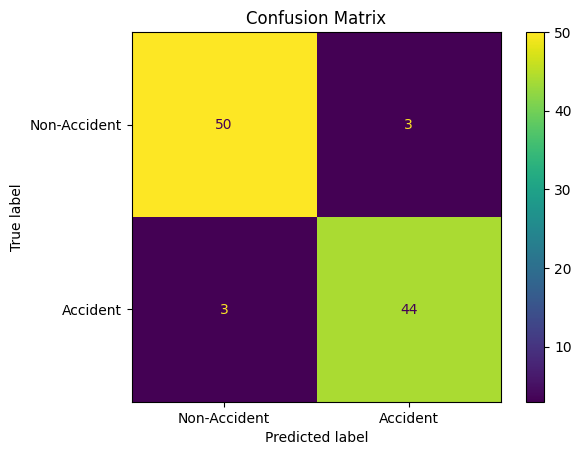


------------------------------------------------------------------------------------------



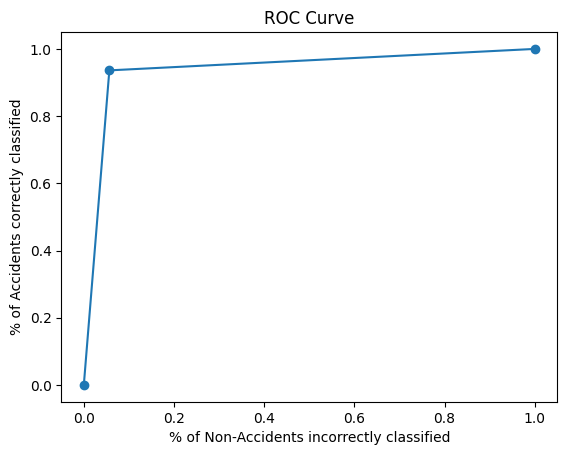


------------------------------------------------------------------------------------------

AUC score is: 0.94


In [26]:
clf.fit(X_train_gray_sc, y_train_final)
pred_gray_val = clf.predict(X_test_gray_sc)
calculate_metrics(pred_gray_val, y_test)

So, the best we could do using **Kernelized SVM** is a test fbeta score (beta = 1.4) of 0.94, with the parameters:
- random_state = 5000
- class_weight = {0:1, 1:1.5}
- max_iter=10000
- C = 6.16583106294135 
- coef0= 10.0
- degree = 3
- gamma = 0.01821022511510858
- kernel = rbf